In [129]:
import math

import fastai
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


from fastai.tabular.all import (
    LinBnDrop
)

from fastai.layers import (
    Identity
)

from pytorch_tabnet.sparsemax import (
    Sparsemax
)

from rff.layers import (
    GaussianEncoding
)

from sklearn.ensemble import (
    RandomForestClassifier
)

from Quick.cleaning.loading import (
    examine_dataset
)

from Quick.cleaning.utils import (
    get_file_path
)

from Quick.runners.deep import (
    run_deep_nn_experiment
)

from Quick.runners.residual import (
    run_residual_deep_nn_experiment
)

from Quick.runners.sk import (
    run_sk_experiment
)

from Quick.runners.torch import (
    run_torch_nn_experiment
)

from Quick.constants import *

In [3]:
data_path_1: str = './data/'
data_sets_1: list = [
    'Darknet_experiments_base.csv'
]

file_path_1: callable = get_file_path(data_path_1)
file_set_1: list = list(map(file_path_1, data_sets_1))
current_job: int = 0

dataset_1 = examine_dataset(0, file_set_1, data_sets_1)
df = dataset_1['Dataset'].sample(frac=0.1, random_state=42)

print('Dataset loaded')
print('Dataset shape: ', dataset_1['Dataset'].shape)
print('Downsampled dataset shape: ', df.shape)

Dataset 0/1: We now look at ./data/Darknet_experiments_base.csv


Loading Dataset: ./data/Darknet_experiments_base.csv
	To Dataset Cache: ./cache/Darknet_experiments_base.csv.pickle


        File:				./data/Darknet_experiments_base.csv  
        Job Number:			0
        Shape:				(117620, 64)
        Samples:			117620 
        Features:			64
    
Dataset loaded
Dataset shape:  (117620, 64)
Downsampled dataset shape:  (11762, 64)


Shape of Input Data: (11762, 63)


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.629301,1.474781,0.600765,0.401740,0.786697,0.458664,0.369095,0.377338,0.401740,00:24
1,1.244118,1.106151,0.711310,0.469717,0.830472,0.594848,0.468634,0.492682,0.469717,00:25
2,1.039898,0.926602,0.733844,0.467398,0.858542,0.624767,0.488894,0.558411,0.467398,00:26
3,0.910268,0.819627,0.764881,0.485685,0.887851,0.672882,0.504796,0.550289,0.485685,00:26
4,0.832950,0.779861,0.771684,0.489457,0.886853,0.680579,0.510994,0.573356,0.489457,00:26
5,0.773011,0.753891,0.770833,0.504256,0.904251,0.682196,0.521707,0.564412,0.504256,00:26
6,0.728493,0.672150,0.783588,0.504778,0.922128,0.695924,0.523997,0.567913,0.504778,00:26
7,0.712514,0.674708,0.788690,0.526573,0.924007,0.706529,0.523601,0.545586,0.526573,00:25
8,0.687583,0.707319,0.789966,0.516184,0.914111,0.710191,0.520153,0.557531,0.516184,00:26
9,0.662604,0.682991,0.784014,0.538724,0.920896,0.701276,0.549351,0.594415,0.538724,00:25


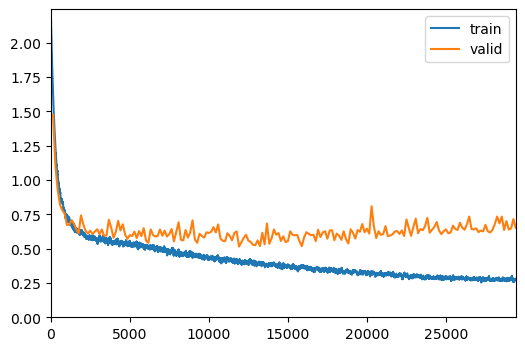

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.6520001888275146, accuracy:  81.68%
Deep NN has 99342 parameters


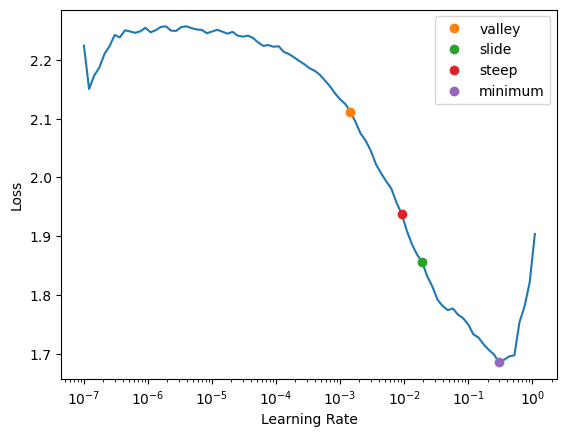

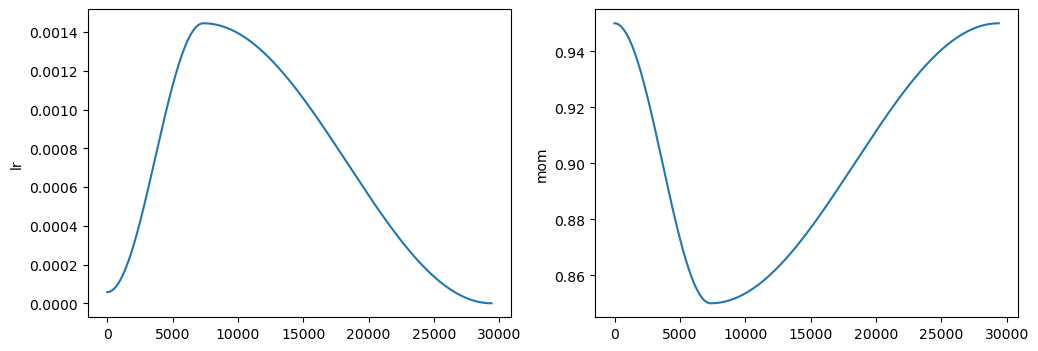

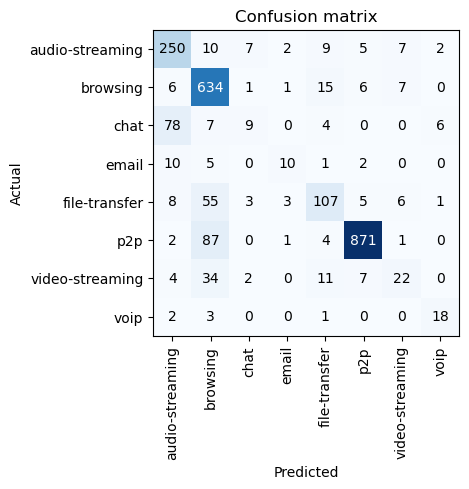

In [8]:
results = run_deep_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type',
    (100 for _ in range(10)),
    epochs=200
)

print(f"Deep NN has {sum(p.numel() for p in results.model.model.model.parameters())} parameters")

In [9]:
results_kkn = run_sk_experiment(df.drop(['Traffic Type'], axis=1), dataset_1['File'], 'Application Type')

Shape of Input Data: (11762, 63)
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       292
           1       0.78      0.90      0.84       670
           2       0.84      0.74      0.79       104
           3       0.71      0.54      0.61        28
           4       0.59      0.48      0.53       188
           5       0.93      0.93      0.93       966
           6       0.53      0.31      0.39        80
           7       0.89      0.67      0.76        24

    accuracy                           0.84      2352
   macro avg       0.77      0.68      0.72      2352
weighted avg       0.83      0.84      0.83      2352

	Accuracy: 0.8397108843537415



In [10]:
# now we try to classify the data using random forest
from sklearn.ensemble import RandomForestClassifier

In [7]:
class Debug_Module(nn.Module):
    def __init__(self, name: str = 'Debug_Module', layers: list = None):
        super().__init__()

        self.name = name
        self.flag = True

        if layers is not None:
            self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.flag:
            print(f'{self.name} - {x.shape}')
            self.flag = False

        return x


In [164]:
def ghost_norm(X, groupsM, eps=1e-05):
    """
        X: Input Tensor with (M, C, F) dimensions
        groupsM: Number of groups for the mini-batch dimension
        eps: A small value to prevent division by zero

        (code taken from https://openreview.net/pdf/6ff818b5b1971be3a97d85efc2fc83ce24b9ef63.pdf)
    """

    # check to see if groupsM is a factor of M
    M, C, F = X.shape

    print(X.shape)

    # if M % groupsM != 0:
    #     raise ValueError("The number of groups must be a factor of the mini-batch size")

    # Split the mini-batch dimension into groups of smaller batches
    X = X.reshape(groupsM, -1, C, F)

    # Calculate statistics over dim(0) x dim(2) number of slices of dim(1) x dim(3) dimension each
    mean = X.mean([1, 3], keepdim=True)
    var = X.var([1, 3], unbiased=False, keepdim=True)

    # Normalize X
    X = (X - mean) / (torch.sqrt(var + eps))

    # Reshape into the initial tensor shape
    X = X.reshape(M, C, F)
    return X

class GhostNorm(nn.Module):
    def __init__(self, num_groups, eps=1e-05, affine=True):
        super().__init__()
        self.num_groups = num_groups
        self.eps = eps
        self.affine = affine
        self.batch_size = None
        self.running_mean = None
        self.running_var = None

        if self.affine:
            self.weight = nn.Parameter(torch.ones(1)) - eps/2
            self.bias = nn.Parameter(torch.zeros(1)) + eps/2

    def forward(self, X):
        B, C, F = X.shape

        if self.batch_size is None:
            self.batch_size = B


        print(X.shape)

        if X.shape[0] != self.batch_size:
        # if B % self.num_groups != 0:
            # we pad the input with random values taken from a normal distribution using the running mean and variance
            # to make sure that the number of groups is a factor of the batch size
            missing_B = self.batch_size - B
            X = torch.cat([X, torch.normal(self.running_mean, self.running_var ** .5, (missing_B, C, F))], dim=0)


        # Split the mini-batch dimension into groups of smaller batches
        X = X.reshape(self.num_groups, -1, C, F)

        # Calculate statistics over dim(0) x dim(2) number of slices of dim(1) x dim(3) dimension each
        mean = X.mean([1, 3], keepdim=True)
        var = X.var([1, 3], unbiased=False, keepdim=True)

        if self.running_mean is None:
            self.running_mean = torch.mean(mean)
            self.running_var = torch.mean(var)
        else:
            self.running_mean = 0.9 * self.running_mean + 0.1 * torch.mean(mean)
            self.running_var = 0.9 * self.running_var + 0.1 * torch.mean(var)

        # Normalize X
        X = (X - mean) / (torch.sqrt(var + self.eps))

        if B != X.shape[0]:
            X = X[:B]

        # Reshape into the initial tensor shape
        X = X.reshape(B, C, F)

        return self.weight * X + self.bias
        

    def extra_repr(self):
        return '{num_features}, num_groups={num_groups}, eps={eps}'.format(**self.__dict__)

In [191]:
class DifferentiableMask(nn.Module):
    '''
        A differentiable mask that can be trained to mask out features in a feature vector

        parameters:
            input_size: the size of the input feature vector
            output_size: the size of the output feature vector

        input shape: (batch_size, input_size)
        output shape: (batch_size, output_size)
    '''

    def __init__(
        self,
        input_size: int = 32,
        output_size: int = 64,
        config: dict = None,
    ):
        super().__init__()

        self.mask_network = None
        self.activation = Sparsemax()

        if config is not None:
            if 'mask_network' in config:
                self.mask_network = config['mask_network']
            if 'activation' in config:
                self.activation = config['activation']
            
            
        hidden_size = max(output_size, 15)

        if self.mask_network is None:

            self.mask_network = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.LeakyReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.LeakyReLU(),
                nn.Linear(hidden_size, output_size),
                self.activation
            )

        else:
            self.mask_network = nn.Sequential(
                self.mask_network(input_size, output_size, hidden_size),
                self.activation
            )


    def forward(self, x):
        return self.mask_network(x)


In [192]:
# basis functions

def standard_wrapping_map(
    x: torch.Tensor
) -> torch.Tensor:
    '''
        A function that wraps a tensor x in the standard wrapping map
            w: R -> S^1 : w(x) = (cos(2*pi*x), sin(2*pi*x)))

        parameters:
            x: the tensor to wrap

        returns:
            the wrapped tensor
    '''

    pi = torch.tensor(math.pi)

    wrapped = torch.cat((torch.cos(2*pi*x), torch.sin(2*pi*x)), dim=1)

    return wrapped


def radial_basis_function(
    x: torch.Tensor, 
    spread: int = 10
) -> torch.Tensor:
    '''
        A radial basis function centered at 0
    '''

    return torch.exp(-1 * spread * torch.pow(x, 2))
  
def morelet_basis_wavelet(
    x: torch.Tensor, 
    spread: int = 10, 
    frequency: int = 15,
    amplitude: int = 1
) -> torch.Tensor:
    '''
        A modified morelet wavelet basis function centered at 0 using both sin and cos
    '''

    wave = standard_wrapping_map(frequency * x)

    radial = radial_basis_function(x, spread).repeat(1, 2)

    return amplitude * wave * radial

def fourier_basis(
    x: torch.Tensor, 
    frequency: int = 15,
    amplitude: int = 1
) -> torch.Tensor:
    '''
        A fourier basis function centered at 0
    '''

    return amplitude * standard_wrapping_map(frequency * x)


def standard_spherical_map(
    x: torch.Tensor,
    y: torch.Tensor
) -> torch.Tensor:
    '''
        A function that wraps a tensor tensors x and y of the same shape in the standard spherical map
    '''

    pi = torch.tensor(math.pi)

    wrapped = torch.cat(
        [
            torch.cos(pi*x),
            torch.sin(pi*x) * torch.cos(2*pi*y), 
            torch.sin(pi*x) * torch.sin(2*pi*y), 
        ], 
        dim=1
    )

    return wrapped



In [290]:
# basis maps

'''
    Here we will make an assortment of maps that take a tensor of shape (encodings, 1) and returns a tensor
        of shape (encodings, 2*dims)

    The maps we will make are:
        1. frequency scaled fourier basis
        2. amplitude scaled fourier basis
        3. sliding radial basis 
        4. sliding morelet wavelet
        5. random fourier basis
        6. 1d spherical map
        7. sliding circular map
'''

def frequency_scaled_fourier_basis(
    x: torch.Tensor,
    dims: int = 25,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        A frequency scaled fourier basis function with amplitude 1
    '''

    basis = torch.cat(
        [
            fourier_basis(x + eps, frequency=i, amplitude=1) for i in range(1, dims + 1)
        ],
        dim=1
    )

    return basis


def frequency_scaled_fourier_exp_basis(
    x: torch.Tensor,
    dims: int = 25,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        A frequency scaled fourier basis function with amplitude 1
    '''

    basis = torch.cat(
        [
            fourier_basis(x + eps, frequency=(2**i), amplitude=1) for i in range(dims)
        ],
        dim=1
    )

    return basis

def amplitude_scaled_fourier_basis(
    x: torch.Tensor,
    dims: int = 25,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        An amplitude scaled fourier basis function with frequency 1
    '''

    basis = torch.cat(
        [
            fourier_basis(x + eps, frequency=1, amplitude=i) for i in range(1, dims+1)
        ],
        dim=1
    )

    return basis

def amplitude_scaled_sliding_fourier_basis(
    x: torch.Tensor,
    dims: int = 25,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        An amplitude scaled fourier basis function with frequency 1
    '''

    basis = torch.cat(
        [
            fourier_basis(x + eps + i/dims, frequency=1, amplitude=i) for i in range(1, dims+1)
        ],
        dim=1
    )

    return basis

def sliding_radial_basis(
    x: torch.Tensor,
    dims: int = 25,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        A sliding radial basis function with frequency 1
    '''

    dims = 2 * dims

    basis = torch.cat(
        [
            radial_basis_function(x + eps - i/dims) for i in range(dims)
        ],
        dim=1
    )

    return basis

def sliding_morelet_wavelet(
    x: torch.Tensor,
    dims: int = 25,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        A sliding morelet wavelet with frequency 1
    '''

    basis = torch.cat(
        [
            morelet_basis_wavelet(x + eps - i/dims) for i in range(dims)
        ],
        dim=1
    )

    return basis
    

def random_fourier_basis( 
    x: torch.Tensor,
    dims: int = 25,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        A random fourier basis
    '''

    randff = GaussianEncoding(1, 1, encoded_size=dims)(x + eps)

    return randff
    

def spherical_wrapping_map_1d(
    x: torch.Tensor, 
    dims: int = 4,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        A function that wraps a tensor x in the spherical wrapping map
            w: R -> R^dim : w(x) = (
                sin(pi*x)^0 * cos(pi*x),
                sin(pi*x)^1 * cos(pi*x),
                sin(pi*x)^2 * cos(pi*x),
                ... , 
                sin(pi*x)^(dim-2) * cos(2*pi*x),
                sin(pi*x)^(dim-2) * sin(2*pi*x) 
            )
    '''

    dims = dims * 2
    x = x + eps

    if dims < 3:
        raise ValueError('dim must be greater than 3, if you need less, use the standard wrapping map')

    pi = torch.tensor(math.pi)

    wrapped = []

    for i in range(dims - 1):
            wrapped.append(torch.sin(2*pi*x)**i * torch.cos(2*pi*x))

    wrapped.append(torch.sin(2*pi*x)**(dims - 1))

    wrapped = torch.cat(wrapped, dim=1)

    return wrapped


def sliding_wrapping_map(
    x: torch.Tensor,
    dims: int = 4,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        A sliding wrapping map
    '''
    
    basis = torch.cat(
        [
            standard_wrapping_map(x + eps + i/dims) for i in range(dims)
        ],
        dim=1
    )

    return basis


In [194]:
# basis simple tests

start = 0
end = 1
points = 100
dims = 25

x = torch.linspace(start, end, points+1).reshape(-1, 1)[:points, :]

l = [
    fourier_basis(x) for _ in range(dims)
]

# torch.cat(l, dim=1)

fsf = frequency_scaled_fourier_basis(x, dims=dims)
asf = amplitude_scaled_fourier_basis(x, dims=dims)
srb = sliding_radial_basis(x, dims=dims)
randff = random_fourier_basis(x, dims=dims)
smw = sliding_morelet_wavelet(x, dims=dims)
swm = spherical_wrapping_map_1d(x, dims=dims)
print(f"frequency scaled fourier basis: {fsf.shape}")
print(f"amplitude scaled fourier basis: {asf.shape}")
print(f"sliding radial basis: {srb.shape}")
print(f"sliding morelet wavelet: {smw.shape}")
print(f"random fourier features: {randff.shape}")
print(f"spherical wrapping map: {swm.shape}")

frequency scaled fourier basis: torch.Size([100, 50])
amplitude scaled fourier basis: torch.Size([100, 50])
sliding radial basis: torch.Size([100, 50])
sliding morelet wavelet: torch.Size([100, 50])
random fourier features: torch.Size([100, 50])
spherical wrapping map: torch.Size([100, 50])


In [195]:
# old basis maps

def standard_wrapping_map(x: torch.Tensor) -> torch.Tensor:
    '''
        A function that wraps a tensor x in the standard wrapping map
            w: R -> S^1 : w(x) = (cos(2*pi*x), sin(2*pi*x)))

        parameters:
            x: the tensor to wrap

        returns:
            the wrapped tensor
    '''

    pi = torch.tensor(math.pi)

    wrapped = torch.cat((torch.cos(2*pi*x), torch.sin(2*pi*x)), dim=1)

    return wrapped

def toroidal_wrapping_map_1d(x: torch.Tensor, dim: int = 4) -> torch.Tensor:
    '''
        A function that wraps a tensor x in the toroidal wrapping map
            w: R -> T^dim : w(x) = (a_0 * cos(2*pi*x), a_0 * sin(2*pi*x), ... , a_(dim-1) * cos(2*pi*x), a_(dim-1) * sin(2*pi*x)) where for i in [0, dim-1], a_i = 1+i/dim
    '''

    pi = torch.tensor(math.pi)

    a = torch.tensor([1 + i/dim for i in range(dim)])

    wrapped = []

    for i in range(dim):

        scaler = 1 + i/dim

        wrapped.append(scaler * torch.cos(2*pi*x))
        wrapped.append(scaler * torch.sin(2*pi*x))

    wrapped = torch.cat(wrapped, dim=1)

    return wrapped

def spherical_wrapping_map_1d(x: torch.Tensor, dim: int = 4) -> torch.Tensor:
    '''
        A function that wraps a tensor x in the spherical wrapping map
            w: R -> R^dim : w(x) = (
                sin(pi*x)^0 * cos(pi*x),
                sin(pi*x)^1 * cos(pi*x),
                sin(pi*x)^2 * cos(pi*x),
                ... , 
                sin(pi*x)^(dim-2) * cos(2*pi*x),
                sin(pi*x)^(dim-2) * sin(2*pi*x) 
            )
    '''

    if dim < 3:
        raise ValueError('dim must be greater than 3, if you need less, use the standard wrapping map')

    pi = torch.tensor(math.pi)

    wrapped = []

    for i in range(dim - 1):
            wrapped.append(torch.sin(2*pi*x)**i * torch.cos(2*pi*x))

    wrapped.append(torch.sin(2*pi*x)**(dim - 1))

    wrapped = torch.cat(wrapped, dim=1)

    return wrapped


def exponential_fourier_map_1d(x: torch.Tensor, dim: int = 4) -> torch.Tensor:
    '''
        A function that sends a tensor x to the fourier map
            f: R -> R^dim : f(x) = (cos(x*2^0),sin(x*2^1), cos(x*2^1), sin(x*2^0), ... , cos(x*2^n, sin(x*2^n)) where n = (dim - 1)

        parameters:
            x: the tensor to send to the fourier map
            dim: the number of fourier features to generate

        returns:
            the fourier features of x
    '''

    fourier_maps = [
        [torch.cos(x * 2**(i-1)), torch.sin(x * 2**(i-1))] for i in range(1, dim + 1)
    ]

    # flatten
    fourier_maps = [item for sublist in fourier_maps for item in sublist]

    fourier = torch.cat(fourier_maps, dim=1)



    for i in range(dim//2):
        fourier_maps.append(torch.sin(x * 2**i))
        fourier_maps.append(torch.cos(x * 2**i))



    fourier = torch.cat([torch.sin(x * 2**i) for i in range(1, dim + 1)], dim=1)

    return fourier

def fourier_map(x: torch.Tensor, dim: int = 4) -> torch.Tensor:
    '''
        A function that sends a tensor x to the fourier map
            f: R-> R^dim : f(x) = (cos(x), sin(x), cos(2x), sin(2x), ..., cos((dim//2)x), sin((dim//2)*x))
    '''


In [291]:
class PositionalEncodingFactory(nn.Module):

    possible_types = [
        'independent', 
        'linear', 
        'circular',
        'frequency_scaled_fourier',
        'frequency_scaled_fourier_exp',
        'amplitude_scaled_fourier',
        'amplitude_scaled_sliding_fourier',
        'sliding_radial_basis',
        'sliding_morelet_wavelet',
        'random_fourier_basis',
        'spherical_wrapping_map_1d',
    ]

    def __init__(
        self,
        encodings: int = 64,
        encoding_type: str = 'independent',
        config: dict = None,
        dims: int = 2,
        verbose: bool = False,
        eps: float = 1e-5
    ):
        super().__init__()
        
        self.positional_encodings = None
        self.encoding_type = encoding_type
        self.encodings = encodings
        self.verbose = verbose
        self.encoder = None
        self.config = config
        self.dims = dims
        self.eps = eps


        if encoding_type not in self.possible_types:
            raise ValueError(f"Positional mask type must be one of {self.possible_types}")

        # if the encoding is independent we need to generate the encodings now
        if encoding_type == 'independent':
            self.positional_encodings = torch.eye(encodings, encodings)

        # if the encoding is random fourier basis we need to generate the encoder now
        elif encoding_type == 'random_fourier_basis':
            enc_std = 1
            
            if config is not None:
                if 'enc_std' in config:
                    enc_std = config['enc_std']

            self.encoder = GaussianEncoding(1, 1, encoded_size=dims)


    def encode(self, eps = None) -> torch.Tensor:
        if self.encoding_type == 'independent':
            return self.positional_encodings

        elif self.encoding_type == 'linear':
            return torch.arange(self.encodings).reshape(-1, 1) / (self.encodings - 1)

        if eps is not None:
            self.eps = eps
            
        domain_points = torch.arange(self.encodings).reshape(-1, 1) / self.encodings    

        if self.encoding_type == 'circular':
            print(f"in circular with eps {self.eps}, dims {self.dims}, and domain points {domain_points.shape} for {self.encodings} encodings on x: {x.shape}")
            return sliding_wrapping_map(domain_points, self.dims, eps=self.eps)

        elif self.encoding_type == 'frequency_scaled_fourier':
            return frequency_scaled_fourier_basis(domain_points, dims=self.dims, eps=self.eps)

        elif self.encoding_type == 'frequency_scaled_fourier_exp':
            return frequency_scaled_fourier_exp_basis(domain_points, dims=self.dims, eps=self.eps)

        elif self.encoding_type == 'amplitude_scaled_fourier':
            return amplitude_scaled_fourier_basis(domain_points, dims=self.dims, eps=self.eps)

        elif self.encoding_type == 'amplitude_scaled_sliding_fourier':
            return amplitude_scaled_sliding_fourier_basis(domain_points, dims=self.dims, eps=self.eps)

        elif self.encoding_type == 'sliding_radial_basis':
            return sliding_radial_basis(domain_points, dims=self.dims, eps=self.eps)

        elif self.encoding_type == 'sliding_morelet_wavelet':
            return sliding_morelet_wavelet(domain_points, dims=self.dims, eps=self.eps)
        
        elif self.encoding_type == 'random_fourier_basis':
            return self.encoder(domain_points + self.eps)

        elif self.encoding_type == 'spherical_wrapping_map_1d':
            return spherical_wrapping_map_1d(domain_points, dims=self.dims, eps=self.eps)


    def encode_with_length(self, length: int, eps: float = None) -> torch.Tensor:
        if self.encoding_type == 'independent':
            raise ValueError('Cannot encode with different length when using independent encodings')

        self.encodings = length

        return self.encode(eps=eps)



In [197]:
# old positional encoding generator
def generate_positional_encodings(
    encodings: int = 64,
    type: str = 'independent',
    config: dict = None,
    dim: int = 2,
    verbose: bool = False,
    eps: float = 1e-5
) -> torch.Tensor:
    '''
        A function that generates positional encodings. These encodings can be
            in one of the following configurations:
                - independent: each encoding is a linearly independent unit vector
                - linear: each encoding is a step in the range [0, 1]
                - circular: each encoding is a step in the range [0, 1] that 
                                then has the standard wrapping map w applied to it

                                w: R -> S^1 : w(x) = (cos(2*pi*x), sin(2*pi*x)))    
        
                - fourier: each encoding is a step in the range [0, 1] that
                                then has the fourier map f applied to it

                                f: R -> R^dim : f(x) = (sin(x*2^1), (sin(x*2^2), ..., sin(x*2^dim))

    '''

    types = [ #some are not implemented here but in the encoding class since we are moving to that implementation
        'independent', 
        'linear', 
        'circular',
        'frequency_scaled_fourier',
        'amplitude_scaled_fourier',
        'sliding_radial_basis',
        'sliding_morelet_wavelet',
        'random_fourier_basis',
        'spherical_wrapping_map_1d',
    ]

    positional_encodings = None

    if type not in types:
        raise ValueError(f"Positional mask type must be one of {types}")

    elif type == 'independent':
         # we produce a binary matrix of size (encodings, encodings) where the diagonal is all 1s and the rest are 0s
            #       this gives us a set of linearly independent vectors,

            positional_encodings = torch.eye(encodings, encodings)


    elif type == 'linear':
        # we produce a matrix of size (encodings, 1) of the form [[0], [1/(m-1)], [2/(m-1)], ..., [1]]
        #       this gives us a set of evenly spaced points on the line from 0 to 1, 

        positional_encodings = torch.arange(encodings).reshape(-1, 1) / (encodings - 1)

    elif type == 'circular':
        # we produce a matrix of size (masks, 1) of the form [[0], [1/m], [2/m], ..., [(m-1)/m]]
        #       then we pass them through the unit circle function to get the circular encoding
        #       this finally gives us a matrix of size (encodings, 2)

        domain_points = torch.arange(encodings).reshape(-1, 1) / encodings
        positional_encodings = standard_wrapping_map(domain_points)
        
    elif type == 'frequency_scaled_fourier':
        # we produce a matrix of size (masks, 1) of the form [[0], [1/m], [2/m], ..., [(m-1)/m]]
        #       then we pass them through the exponential fourier map to get the fourier encoding
        #       this finally gives us a matrix of size (encodings, 2*dim)

        domain_points = torch.arange(encodings).reshape(-1, 1) / encodings
        positional_encodings = frequency_scaled_fourier_basis(domain_points, dims=dim, eps=eps)

    elif type == 'amplitude_scaled_fourier':
        # we produce a matrix of size (masks, 1) of the form [[0], [1/m], [2/m], ..., [(m-1)/m]]
        #      then we pass them through the amplitude scaled fourier map to get the fourier encoding
        #      this finally gives us a matrix of size (encodings, 2*dim)


        domain_points = torch.arange(encodings).reshape(-1, 1) / encodings


    if verbose:
        print(f"Generated {encodings} positional encodings of shape {positional_encodings.shape} with type {type}")

    return positional_encodings


In [198]:
torch.set_printoptions(sci_mode=False)

In [199]:
# old SparsePositionalFilter


class SparsePositionalFilter(nn.Module):
    '''
        A sparse filter that takes a set of generated positional encodings and uses them to 
            find a set of sparse neighboorhoods of the input corresponding to the positional encodings.

        These sparse neighborhoods are then passed through a kernel to produce a single output feature. 
            If the kernel has more than one output, they are considered to be in separate channels.

        An output feature is calculated for each positional encoding, and the final output is a concatenation
            of all of these features.


        Algorithm: Sparse Convolution

            B  = batch size
            C  = input channels
            C' = output channels
            F  = input features
            F' = output features
            D  = positional encoding length

            Let X be an input tensor of shape (B, C, F)

            Let P be a set of positional encodings of shape (F', D)

            Let the kernel, K, be a MLP that defining a function K: R^(B * C * F) -> R^(B * C' * 1)

            for each i <= F':
                Let N_i = X * Sparsemax(MLP(P_i)) where * is the elementwise produce across the feature dimension

                Let O_i = K(N_i)

            Let O be the concatenation of all O_i along the feature dimension
                
        Then O is the output of the filter, and has shape (B, C', F')
    '''

    def __init__(
        self,
        features = 64, 
        channels = 1,
        filter_width = 1,
        num_encodings = 64,
        positional_type = 'independent',
        config: dict = None,
        verbose: bool = False
    ) -> None:
        super().__init__()

        self.features = features
        self.channels = channels
        self.filter_width = filter_width
        self.verbose = verbose
        self.positional_type = positional_type

        self.positional_encodings = generate_positional_encodings(
            encodings = num_encodings, 
            type = positional_type
        )

        self.neighborhood = DifferentiableMask(
            input_size=self.positional_encodings.shape[1], 
            output_size=features,
            config=config, 
        )

        self.kernel = nn.Sequential(
            nn.Flatten(),
            nn.Linear(features * channels, self.filter_width, bias=False),
            nn.Unflatten(dim=1, unflattened_size=(self.filter_width, 1))
        )

        self.flag: bool = verbose
        self.local_flag: bool = verbose


    def resize_positional_encodings(self, encodings: int = 64) -> None:
        '''
            A function that resizes the positional encodings
        '''

        if self.positional_type == 'independent':
            raise ValueError("Cannot resize independent positional encodings")

        self.positional_encodings = generate_positional_encodings(
            encodings = encodings, 
            type = self.positional_type
        )


    def get_neighborhood_masks(self) -> torch.Tensor:
        '''
            A function that returns the neighborhood masks
        '''

        return self.neighborhood(self.positional_encodings)


    def get_neighborhood_masks_with_length(self, length: int) -> torch.Tensor:
        '''
            A function that returns the neighborhood masks with a specified length
        '''

        return self.neighborhood(
            generate_positional_encodings(
                encodings = length,
                type = self.positional_type
            )
        )


    def forward(self, x):

        mask = self.neighborhood(self.positional_encodings)

        if self.flag:
            print(f"Input shape: {x.shape}")
            print(f"Positional Encodings shape: {self.positional_encodings.shape}")
            print(f"Poisitonal Encodings:\n {self.positional_encodings}")
            print(f"Mask shape: {mask.shape}")
            print(f"Mask:\n {mask}")

        outputs = []

        for i in range(self.positional_encodings.shape[0]):
            neighborhood = x * mask[i]

            outputs.append(
                self.kernel(neighborhood)
            )

            if self.local_flag:
                print(f"Neighborhood shape: {neighborhood.shape}")
                print(f"Neighborhood:\n {neighborhood}")
                print(f"Output shape: {outputs[-1].shape}")
                print(f"Output:\n {outputs[-1]}")

                self.local_flag = False

        output = torch.cat(outputs, dim=2)

        if self.flag:
            print(f"Final output shape: {output.shape}")
            print(f"Final output:\n {output}")

            self.flag = False

        return output

batch_size = 2
features = 6
channels = 5
filter_width = 3
encodings = 3


test_vals = torch.randn(batch_size, channels, features)

test_filter = SparsePositionalFilter(features=features, filter_width=filter_width, channels=channels, num_encodings=encodings, verbose=True)
print(f"Sparse filter with input shape {test_vals.shape}, encoding length {encodings}, and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter(test_vals)

Sparse filter with input shape torch.Size([2, 5, 6]), encoding length 3, and filter_width 3 has 486 parameters
Input shape: torch.Size([2, 5, 6])
Positional Encodings shape: torch.Size([3, 3])
Poisitonal Encodings:
 tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
Mask shape: torch.Size([3, 6])
Mask:
 tensor([[0.0766, 0.0000, 0.3009, 0.0578, 0.1723, 0.3924],
        [0.1312, 0.0000, 0.2927, 0.0228, 0.0326, 0.5206],
        [0.1174, 0.0000, 0.2902, 0.0739, 0.0550, 0.4636]],
       grad_fn=<SparsemaxFunctionBackward>)
Neighborhood shape: torch.Size([2, 5, 6])
Neighborhood:
 tensor([[[ 0.0482,  0.0000, -0.1210, -0.0056, -0.1381, -0.3028],
         [-0.0076,  0.0000,  0.2870, -0.0459, -0.0035,  0.0692],
         [ 0.0521, -0.0000, -0.2046, -0.0688,  0.0814, -0.5584],
         [ 0.2001, -0.0000, -0.3386, -0.0264, -0.0675,  0.6212],
         [-0.0662,  0.0000, -0.5910, -0.0730, -0.1968, -0.0259]],

        [[ 0.0672, -0.0000, -0.1561,  0.0219, -0.1563, -0.4913],
         [ 

tensor([[[ 0.0038, -0.0156, -0.0113],
         [-0.0065,  0.0202,  0.0165],
         [-0.0335, -0.0239, -0.0269]],

        [[ 0.0111, -0.0075,  0.0037],
         [ 0.1410,  0.1375,  0.1546],
         [ 0.0404,  0.0692,  0.0678]]], grad_fn=<CatBackward0>)

In [200]:
import matplotlib.pyplot as plt

Positional encodings shape: torch.Size([100, 100])
Positional encodings:
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
Kernel output shape: torch.Size([5, 3, 1])
Kernel output:
 tensor([[[     0.0254],
         [     0.1250],
         [     0.1703]],

        [[     0.1288],
         [    -0.3323],
         [     0.4758]],

        [[    -0.3343],
         [    -0.0688],
         [    -0.0550]],

        [[     0.0498],
         [     0.0003],
         [     0.1602]],

        [[    -0.3169],
         [     0.0317],
         [    -0.7618]]], grad_fn=<ViewBackward0>)


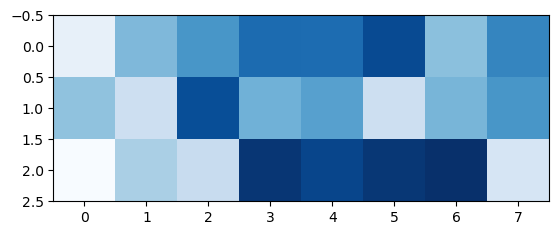

In [201]:
class PositionalEmbeddingKernel_old(nn.Module):
    '''
        Defines a kernel that takes an input and a positional encoding and produces 
            a single output feature for each i <= filter_width

        The kernel is defined as a 2-layer MLP that takes the input and an embedding 
            of the positional encoding as input and produces a single output feature. 
 

    '''
    def __init__(
        self,
        positional_encoding_shape: tuple,
        features: int,
        channels: int,
        filter_width: int,
        config: dict = None,
    ) -> None:
        super().__init__()

        self.positional_encoding_shape = positional_encoding_shape
        self.filter_width = filter_width
        self.features = features
        self.channels = channels

        self.embedding_size = min(features, 10)
        self.embedding = None
        self.kernel = None

        self.before_kernel = nn.Flatten()

        if config is not None:
            if 'embedding_size' in config:
                self.embedding_size = config['embedding_size']
            if 'embedding' in config:
                self.embedding = config['embedding'](positional_encoding_shape[1], self.embedding_size)
            if 'kernel' in config:
                self.kernel = config['kernel'](features * channels + self.embedding_size, self.filter_width)

        if self.embedding is None:
            self.embedding = nn.Sequential(
                nn.Linear(positional_encoding_shape[1], self.embedding_size, bias=False),
            )

        if self.kernel is None:
            self.kernel = nn.Sequential(
                nn.Linear(features * channels + self.embedding_size, self.filter_width, bias=False),
                nn.Unflatten(dim=1, unflattened_size=(self.filter_width, 1))
            )


    def get_kernel_map(self) -> torch.Tensor:
        '''
            this method returns the weights of the kernel in a (features * channels, filter_width) tensor
        '''

        out = self.kernel[0].weight

        return out

    
    def print_kernel_map(self, verbose: bool = False, cmap: str = 'Blues') -> None:
        '''
            this method prints the weights of the kernel in a (features * channels, filter_width) tensor
                the weights are min-max normalized to be in the range [0, 1]
                then 0 is mapped to (0,0,0) and all values greater than zero are multiplied by (0, 0, 255)
                to give a blue gradient

            the image is then printed via matplotlib
        '''

        kernel_map = self.get_kernel_map()

        kernel_map = (kernel_map - torch.min(kernel_map)) / (torch.max(kernel_map) - torch.min(kernel_map))

        if verbose:
            print(kernel_map)

        plt.imshow(kernel_map.detach().numpy(), cmap=cmap)


    def forward(self, x, positional_encoding) -> torch.Tensor:

        pos = positional_encoding.reshape(1, -1)

        embedding = self.embedding(pos).repeat(x.shape[0], 1)

        x = self.before_kernel(x)

        # print(f"Input shape: {x.shape}")
        # print(f"Embedding shape: {embedding.shape}")

        output = self.kernel(torch.cat([x, embedding], dim=1))

        return output

    def f2(self, x, positional_encoding) -> torch.Tensor:

        positions, batch_size, channels, features = x.shape
        assert positions == self.positional_encoding_shape[0]

        


        embedding = self.embedding(positional_encoding).repeat(batch_size, 1)

        
        


encodings = 100
# pos = generate_positional_encodings(encodings=encodings, type='independent')
encoder = PositionalEncodingFactory(encodings=encodings, encoding_type='independent')
pos = encoder.encode()
print(f"Positional encodings shape: {pos.shape}")
print(f"Positional encodings:\n {pos}")
positional_encoding_shape = pos.shape
batch_size = 5
channels = 1
features = 4
filter_width = 3

test_vals = torch.randn(batch_size, channels, features)
test_vals

ker = PositionalEmbeddingKernel_old(
    positional_encoding_shape=positional_encoding_shape, 
    features=features, 
    channels=channels, 
    filter_width=filter_width
)

vals = ker(
    test_vals, 
    pos[0]
)

print(f"Kernel output shape: {vals.shape}")
print(f"Kernel output:\n {vals}")
# pos[0].reshape(1, -1).shape
ker.print_kernel_map()

In [202]:
batch_size = 5
channels = 1
features = 4

test_vals = torch.randn(batch_size, features)
GaussianEncoding(1, 4, encoded_size=2)(test_vals)

tensor([[-0.9910, -0.6696, -0.1337, -0.7428],
        [-0.9979,  0.1796,  0.0643,  0.9837],
        [-0.5499, -0.1268, -0.8352, -0.9919],
        [-0.5844, -0.1031, -0.8115,  0.9947],
        [ 0.2175, -0.6989,  0.9761, -0.7152]])

In [218]:
class RFFMaskNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int) -> None:
        super().__init__()

        self.out = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                GaussianEncoding(1, hidden_size, encoded_size=hidden_size),
                nn.LeakyReLU(),
                nn.Linear(2*hidden_size, hidden_size),
                GaussianEncoding(1, hidden_size, encoded_size=hidden_size),
                nn.LeakyReLU(),
                nn.Linear(2*hidden_size, output_size),
            )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.out(x)


class SinMaskNetwork(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int) -> None:
        super().__init__()

        self.out_1 = nn.Linear(input_size, hidden_size)
        self.out_2 = nn.Linear(hidden_size, hidden_size)
        self.out_3 = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.sin(self.out_1(x))
        x = torch.sin(self.out_2(x))
        return self.out_3(x)

in circular with eps 1e-05, dims 25, and domain points torch.Size([1024, 1]) for 1024 encodings on x: torch.Size([100, 1])
Sparse filter with input shape torch.Size([2, 5, 128]), encoding length 1024, and filter_width 3 has 42002 parameters
Input shape: torch.Size([2, 5, 128])
features: 128
channels: 5
filter_width: 3
num_encodings: 1024
Positional Encodings shape: torch.Size([1024, 50])
Mask shape: torch.Size([1024, 128])
Mask:
 tensor([[0.0019, 0.0000, 0.0000,  ..., 0.0000, 0.0445, 0.0000],
        [0.0015, 0.0000, 0.0000,  ..., 0.0000, 0.0449, 0.0000],
        [0.0010, 0.0000, 0.0000,  ..., 0.0000, 0.0452, 0.0000],
        ...,
        [0.0033, 0.0000, 0.0000,  ..., 0.0000, 0.0434, 0.0000],
        [0.0028, 0.0000, 0.0000,  ..., 0.0000, 0.0438, 0.0000],
        [0.0024, 0.0000, 0.0000,  ..., 0.0000, 0.0441, 0.0000]],
       grad_fn=<SparsemaxFunctionBackward>)
Neighborhood shape: torch.Size([2, 5, 128])
Output shape: torch.Size([2, 3, 1])
Final output shape: torch.Size([2, 3, 1024])

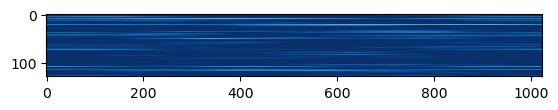

In [270]:
# version pre einsum

class SparsePositionalEmbeddingFilter1(nn.Module):
    '''
        A sparse filter that takes a set of generated positional encodings and uses them to 
            find a set of sparse neighboorhoods of the input corresponding to the positional encodings.

        These sparse neighborhoods are then passed through a kernel to produce a single output feature. 
            If the kernel has more than one output, they are considered to be in separate channels.

        An output feature is calculated for each positional encoding, and the final output is a concatenation
            of all of these features.


        Algorithm: Sparse Convolution

            B  = batch size
            C  = input channels
            C' = output channels
            F  = input features
            F' = output features
            D  = positional encoding length

            Let X be an input tensor of shape (B, C, F)

            Let P be a set of positional encodings of shape (F', D)

            Let the kernel, K, be a MLP that defining a function K: R^(B * C * F) x R^D -> R^(B * C' * 1)

            for each i <= F':
                Let N_i = X * Sparsemax(MLP(P_i)) where * is the elementwise produce across the feature dimension

                Let O_i = K(N_i, P_i)

            Let O be the concatenation of all O_i along the feature dimension
                
        Then O is the output of the filter, and has shape (B, C', F')
    '''

    def __init__(
        self,
        features = 64, 
        channels = 1,
        filter_width = 1,
        num_encodings = 64,
        positional_type = 'independent',
        config: dict = None,
        verbose: bool = False,
        eps: float = 1e-5,
        dims: int = 25
    ) -> None:
        super().__init__()

        self.features = features
        self.channels = channels
        self.filter_width = filter_width
        self.verbose = verbose
        self.positional_type = positional_type
        self.num_encodings = num_encodings

        self.encoder = PositionalEncodingFactory(
            encodings=num_encodings, 
            encoding_type=positional_type, 
            dims=dims,
            config=config,
            verbose=verbose,
            eps=eps
        )

        self.positional_encodings = self.encoder.encode()

        self.neighborhood = DifferentiableMask(
            input_size=self.positional_encodings.shape[1], 
            output_size=features,
            config=config, 
        )

        self.kernel = PositionalEmbeddingKernel_old(
            self.positional_encodings.shape,
            features,
            channels,
            filter_width,
            config=config
        )

        self.flag: bool = verbose
        self.local_flag: bool = verbose



    def resize_positional_encodings(self, num_encodings: int = 64) -> None:
        '''
            A function that resizes the positional encodings
        '''

        if self.positional_type == 'independent':
            raise ValueError("Cannot resize independent positional encodings")

        # self.positional_encodings = generate_positional_encodings(
        #     encodings = encodings, 
        #     type = self.positional_type
        # )
        self.num_encodings = encodings
        self.positional_encodings = self.encoder.encode_with_length(num_encodings)


    def get_neighborhood_masks(self) -> torch.Tensor:
        '''
            A function that returns the neighborhood masks
        '''

        return self.neighborhood(self.positional_encodings)


    def print_neighborhood_masks(self) -> None:
        '''
            this method prints the output of the neighborhood mask function in a (features, encodings) tensor
                the weights are min-max normalized to be in the range [0, 1]
                then 0 is mapped to (0,0,0) and all values greater than zero are multiplied by (0, 0, 255)
                to give a blue gradient

            the image is then printed via matplotlib
        '''

        neighborhood_masks = self.get_neighborhood_masks()

        neighborhood_masks = (neighborhood_masks - torch.min(neighborhood_masks)) / (torch.max(neighborhood_masks) - torch.min(neighborhood_masks))

        # rgb = torch.tensor([0, 0, 255])
        # neighborhood_masks = torch.einsum('ij, k -> ijk', neighborhood_masks, rgb)

        plt.imshow(neighborhood_masks.detach().T.numpy(), cmap='Blues_r')



    def get_neighborhood_masks_with_length(self, length: int) -> torch.Tensor:
        '''
            A function that returns the neighborhood masks with a specified length
        '''

        return self.neighborhood(
            generate_positional_encodings(
                encodings = length,
                type = self.positional_type
            )
        )


    


    def forward(self, x):

        mask = self.neighborhood(self.positional_encodings)

        if self.flag:
            print(f"Input shape: {x.shape}")
            print(f"features: {self.features}")
            print(f"channels: {self.channels}")
            print(f"filter_width: {self.filter_width}")
            print(f"num_encodings: {self.positional_encodings.shape[0]}")
            print(f"Positional Encodings shape: {self.positional_encodings.shape}")
            # print(f"Poisitonal Encodings:\n {self.positional_encodings}")
            print(f"Mask shape: {mask.shape}")
            print(f"Mask:\n {mask}")

        outputs = []

        for i in range(self.positional_encodings.shape[0]):
            
            try:
                neighborhood = x * mask[i]
            except Exception as e:
                print(f'x shape: {x.shape}')
                print(f'mask shape: {mask.shape}')
                print(f'i: {i}')
                print(f'mask[i] shape: {mask[i].shape}')
                raise e

            outputs.append(
                self.kernel(neighborhood, self.positional_encodings[i])
            )

            if self.local_flag:
                print(f"Neighborhood shape: {neighborhood.shape}")
                # print(f"Neighborhood:\n {neighborhood}")
                print(f"Output shape: {outputs[-1].shape}")
                # print(f"Output:\n {outputs[-1]}")

                self.local_flag = False

        output = torch.cat(outputs, dim=2)

        if self.flag:
            print(f"Final output shape: {output.shape}")
            # print(f"Final output:\n {output}")

            self.flag = False

        return output

batch_size = 2
features = 128
channels = 5
filter_width = 3
encodings = 1024


test_vals = torch.randn(batch_size, channels, features)

test_filter = SparsePositionalEmbeddingFilter1(
    features=features, 
    filter_width=filter_width, 
    channels=channels, 
    num_encodings=encodings,
    positional_type='circular',
    verbose=True,
    # dims=2
)
print(f"Sparse filter with input shape {test_vals.shape}, encoding length {encodings}, and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter.print_neighborhood_masks()
test_out = test_filter(test_vals)
# test_out

In [329]:
class PositionalEmbeddingKernel(nn.Module):
    '''
        Defines a kernel that takes an input and a positional encoding and produces 
            a single output feature for each i <= filter_width

        The kernel is defined as a 2-layer MLP that takes the input and an embedding 
            of the positional encoding as input and produces a single output feature. 
    '''
    def __init__(
        self,
        positional_encoding_shape: tuple,
        features: int,
        channels: int,
        filter_width: int,
        config: dict = None,
    ) -> None:
        super().__init__()

        self.positional_encoding_shape = positional_encoding_shape
        self.filter_width = filter_width
        self.features = features
        self.channels = channels

        self.embedding_size = min(features, 10)
        self.embedding = None
        self.kernel = None

        self.before_kernel = nn.Flatten()

        if config is not None:
            if 'embedding_size' in config:
                self.embedding_size = config['embedding_size']
            if 'embedding' in config:
                self.embedding = config['embedding'](positional_encoding_shape[1], self.embedding_size)
            if 'kernel' in config:
                self.kernel = config['kernel'](features * channels + self.embedding_size, self.filter_width)

        if self.embedding is None:
            self.embedding = nn.Sequential(
                nn.Linear(positional_encoding_shape[1], self.embedding_size, bias=False),
            )

        if self.kernel is None:
            self.kernel = nn.Sequential(
                nn.Linear(features * channels + self.embedding_size, self.filter_width, bias=False),
                nn.Unflatten(dim=1, unflattened_size=(self.filter_width, 1))
            )


    def get_kernel_map(self) -> torch.Tensor:
        '''
            this method returns the weights of the kernel in a (features * channels, filter_width) tensor
        '''

        out = self.kernel[0].weight

        return out

    
    def print_kernel_map(self, verbose: bool = False, cmap: str = 'Blues') -> None:
        '''
            this method prints the weights of the kernel in a (features * channels, filter_width) tensor
                the weights are min-max normalized to be in the range [0, 1]
                then 0 is mapped to (0,0,0) and all values greater than zero are multiplied by (0, 0, 255)
                to give a blue gradient

            the image is then printed via matplotlib
        '''

        kernel_map = self.get_kernel_map()

        kernel_map = (kernel_map - torch.min(kernel_map)) / (torch.max(kernel_map) - torch.min(kernel_map))

        if verbose:
            print(kernel_map)

        plt.imshow(kernel_map.detach().numpy(), cmap=cmap)


    def f_old(self, x, positional_encoding) -> torch.Tensor:

        pos = positional_encoding.reshape(1, -1)

        embedding = self.embedding(pos).repeat(x.shape[0], 1)

        x = self.before_kernel(x)

        # print(f"Input shape: {x.shape}")
        # print(f"Embedding shape: {embedding.shape}")

        output = self.kernel(torch.cat([x, embedding], dim=1))

        return output

    def forward(self, x, positional_encoding) -> torch.Tensor:

        positions, batch_size, channels, features = x.shape
        coords = positional_encoding.shape[1]
        assert positions == self.positional_encoding_shape[0]

        print(f"Input shape: {x.shape}")
        print(f"Positional Encoding shape: {positional_encoding.shape}")
        embedding: torch.Tensor = self.embedding(positional_encoding).reshape(positions, 1, self.embedding_size).repeat(1, batch_size, 1)
        print(f"Embedding shape: {embedding.shape}")
        x = x.reshape(positions, batch_size, channels * features)
        x_embed = torch.cat([x, embedding], dim=2).reshape(positions * batch_size, channels * features + self.embedding_size)
        print(f"X Embed shape: {x_embed.shape}")
        output = self.kernel(x_embed).reshape(positions, batch_size, self.filter_width).permute(1, 2, 0)
        print(f"Output shape: {output.shape}")

        return output

In [372]:
samples = 6
variables = 6
test_vals = torch.cat(
    [torch.linspace(0, 1, variables).reshape(1, -1) for _ in range(samples)],
    dim=0
)
timesteps = 2
# test_vals = torch.randn(samples, variables)
print(test_vals)
# we want to compile this into a time series of shape (samples/timesteps, variables, timesteps)
test_vals_2 = torch.cat(
    [test_vals[i:i+timesteps].permute(1,0).reshape(1, variables, timesteps) for i in range(samples - timesteps + 1)],
    dim=0
)
print(test_vals_2)
# i = 0
# tv_slice = test_vals[i:i+timesteps]
# print(tv_slice)
# print(tv_slice.permute(1, 0).reshape(1, variables, timesteps))

tensor([[0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000],
        [0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000],
        [0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000],
        [0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000],
        [0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000],
        [0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000]])
tensor([[[0.0000, 0.0000],
         [0.2000, 0.2000],
         [0.4000, 0.4000],
         [0.6000, 0.6000],
         [0.8000, 0.8000],
         [1.0000, 1.0000]],

        [[0.0000, 0.0000],
         [0.2000, 0.2000],
         [0.4000, 0.4000],
         [0.6000, 0.6000],
         [0.8000, 0.8000],
         [1.0000, 1.0000]],

        [[0.0000, 0.0000],
         [0.2000, 0.2000],
         [0.4000, 0.4000],
         [0.6000, 0.6000],
         [0.8000, 0.8000],
         [1.0000, 1.0000]],

        [[0.0000, 0.0000],
         [0.2000, 0.2000],
         [0.4000, 0.4000],
         [0.6000, 0.6000],
         [0.8000, 0.8000],
         [1.0000, 1.0000

Positional encodings shape: torch.Size([64, 50])
num encodings: 64
Sparse filter with input shape torch.Size([2, 5, 128]), encoding length 64, and filter_width 3 has 42002 parameters
hello
Input shape: torch.Size([2, 5, 128])
Mask shape: torch.Size([64, 128])
features: 128
channels: 5
filter_width: 3
num_encodings: 64
Positional Encodings shape: torch.Size([64, 50])
Neighborhood shape: torch.Size([64, 2, 5, 128])
Input shape: torch.Size([64, 2, 5, 128])
Positional Encoding shape: torch.Size([64, 50])
Embedding shape: torch.Size([64, 2, 10])
X Embed shape: torch.Size([128, 650])
Output shape: torch.Size([2, 3, 64])
Final output shape: torch.Size([2, 3, 64])
Saving neighborhood masks to ./neighborhood_masks/760714


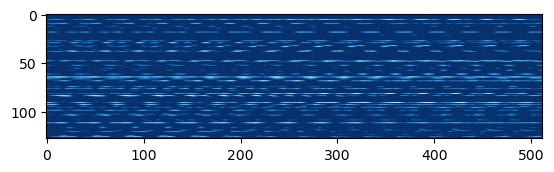

In [346]:
from random import randint
import os

class SparsePositionalEmbeddingFilter(nn.Module):
    '''
        A sparse filter that takes a set of generated positional encodings and uses them to 
            find a set of sparse neighboorhoods of the input corresponding to the positional encodings.

        These sparse neighborhoods are then passed through a kernel to produce a single output feature. 
            If the kernel has more than one output, they are considered to be in separate channels.

        An output feature is calculated for each positional encoding, and the final output is a concatenation
            of all of these features.


        Algorithm: Sparse Convolution

            B  = batch size
            C  = input channels
            C' = output channels
            F  = input features
            F' = output features
            D  = positional encoding length

            Let X be an input tensor of shape (B, C, F)

            Let P be a set of positional encodings of shape (F', D)

            Let the kernel, K, be a MLP that defining a function K: R^(B * C * F) x R^D -> R^(B * C' * 1)

            for each i <= F':
                Let N_i = X * Sparsemax(MLP(P_i)) where * is the elementwise produce across the feature dimension

                Let O_i = K(N_i, P_i)

            Let O be the concatenation of all O_i along the feature dimension
                
        Then O is the output of the filter, and has shape (B, C', F')
    '''

    def __init__(
        self,
        features = 64, 
        channels = 1,
        filter_width = 1,
        num_encodings = 64,
        positional_type = 'independent',
        config: dict = None,
        verbose: bool = False,
        eps: float = 1e-5,
        dims: int = 25
    ) -> None:
        super().__init__()

        self.features = features
        self.channels = channels
        self.filter_width = filter_width
        self.verbose = verbose
        self.positional_type = positional_type
        self.num_encodings = num_encodings
        # we set a random folder name to save neighborhood masks to
        self.rand_folder_index = str(randint(0, 1000000))
        self.mask_index = 0

        self.encoder = PositionalEncodingFactory(
            encodings=num_encodings, 
            encoding_type=positional_type, 
            dims=dims,
            config=config,
            verbose=verbose,
            eps=eps
        )

        self.positional_encodings = self.encoder.encode()

        print(f"Positional encodings shape: {self.positional_encodings.shape}")
        print(f"num encodings: {num_encodings}")

        self.neighborhood = DifferentiableMask(
            input_size=self.positional_encodings.shape[1], 
            output_size=features,
            config=config, 
        )

        self.kernel = PositionalEmbeddingKernel(
            self.positional_encodings.shape,
            features,
            channels,
            filter_width,
            config=config
        )

        self.flag: bool = verbose
        self.local_flag: bool = verbose
        self.print_path_flag: bool = True



    def resize_positional_encodings(self, num_encodings: int = 64, keep_new: bool = True) -> None:
        '''
            A function that resizes the positional encodings
        '''

        if self.positional_type == 'independent':
            raise ValueError("Cannot resize independent positional encodings")

        if keep_new:
            self.num_encodings = encodings
        self.positional_encodings = self.encoder.encode_with_length(num_encodings)


    def get_neighborhood_masks(self) -> torch.Tensor:
        '''
            A function that returns the neighborhood masks
        '''

        return self.neighborhood(self.positional_encodings)


    def print_neighborhood_masks(self) -> None:
        '''
            this method prints the output of the neighborhood mask function in a (features, encodings) tensor
                the weights are min-max normalized to be in the range [0, 1]
                then 0 is mapped to (0,0,0) and all values greater than zero are multiplied by (0, 0, 255)
                to give a blue gradient

            the image is then printed via matplotlib
        '''

        neighborhood_masks = self.get_neighborhood_masks()

        neighborhood_masks = (neighborhood_masks - torch.min(neighborhood_masks)) / (torch.max(neighborhood_masks) - torch.min(neighborhood_masks))

        plt.imshow(neighborhood_masks.detach().T.numpy(), cmap='Blues_r')

    def save_neighborhood_masks(self) -> None:

        if self.print_path_flag:
            print(f"Saving neighborhood masks to ./neighborhood_masks/{self.rand_folder_index}")
            self.print_path_flag = False

        neighborhood_masks = self.get_neighborhood_masks()
        index = self.mask_index
        self.mask_index += 1

        neighborhood_masks = (neighborhood_masks - torch.min(neighborhood_masks)) / (torch.max(neighborhood_masks) - torch.min(neighborhood_masks))

        # now we make sure the folder exists
        if not os.path.exists(f"./neighborhood_masks/{self.rand_folder_index}"):
            os.makedirs(f"./neighborhood_masks/{self.rand_folder_index}")

        plt.imsave(
            f"./neighborhood_masks/{self.rand_folder_index}/{index}.png", 
            neighborhood_masks.detach().T.numpy(), 
            cmap='Blues_r'
        )




    def get_neighborhood_masks_with_length(self, length: int) -> torch.Tensor:
        '''
            A function that returns the neighborhood masks with a specified length
        '''

        return self.neighborhood(
            self.encoder.encode_with_length(length)
        )



    def f_old(self, x):

        mask = self.neighborhood(self.positional_encodings)
        nb = torch.einsum('bcf, pf -> pbcf', x, mask)

        if self.flag:
            print(f"Input shape: {x.shape}")
            print(f"Mask shape: {mask.shape}")
            print(f"features: {self.features}")
            print(f"channels: {self.channels}")
            print(f"filter_width: {self.filter_width}")
            print(f"num_encodings: {self.positional_encodings.shape[0]}")
            print(f"Positional Encodings shape: {self.positional_encodings.shape}")
            print(f"einsum nb shape: {nb.shape}")
            print(f"einsum nb [0]:\n {nb[0]}")
            # print(f"Poisitonal Encodings:\n {self.positional_encodings}")
            # print(f"Mask:\n {mask}")

        outputs = []


        for i in range(self.positional_encodings.shape[0]):
            
            try:
                neighborhood = x * mask[i]
            except Exception as e:
                print(f'x shape: {x.shape}')
                print(f'mask shape: {mask.shape}')
                print(f'i: {i}')
                print(f'mask[i] shape: {mask[i].shape}')
                raise e

            outputs.append(
                self.kernel.f_old(neighborhood, self.positional_encodings[i])
            )

            if self.local_flag:
                print(f"Neighborhood shape: {neighborhood.shape}")
                print(f"Neighborhood:\n {neighborhood}")
                print(f"Output shape: {outputs[-1].shape}")
                # print(f"Output:\n {outputs[-1]}")

                self.local_flag = False

        output = torch.cat(outputs, dim=2)
        out2 = self.kernel(nb, self.positional_encodings)

        if self.flag:
            print(f"Final output shape: {output.shape}")
            print(f"Final output 2 shape: {out2.shape}")
            print(f"Final output:\n {output}")
            print(f"Final output 2:\n {out2}")

            self.flag = False

        return output


    def forward(self, x):

        if self.training:
            print('hello')

        mask = self.neighborhood(self.positional_encodings)
        nb = torch.einsum('bcf, pf -> pbcf', x, mask)

        if self.flag:
            print(f"Input shape: {x.shape}")
            print(f"Mask shape: {mask.shape}")
            print(f"features: {self.features}")
            print(f"channels: {self.channels}")
            print(f"filter_width: {self.filter_width}")
            print(f"num_encodings: {self.positional_encodings.shape[0]}")
            print(f"Positional Encodings shape: {self.positional_encodings.shape}")
            print(f"Neighborhood shape: {nb.shape}")

        output = self.kernel(nb, self.positional_encodings)

        if self.flag:
            print(f"Final output shape: {output.shape}")
            # print(f"Final output:\n {output}")

            self.flag = False

        return output



batch_size = 2
features = 128
channels = 5
filter_width = 3
encodings = 64

possible_types = [
    'independent', 
    'linear', 
    'circular',
    'frequency_scaled_fourier',
    'frequency_scaled_fourier_exp',
    'amplitude_scaled_fourier',
    'amplitude_scaled_sliding_fourier',
    'sliding_radial_basis',
    'sliding_morelet_wavelet',
    'random_fourier_basis',
    'spherical_wrapping_map_1d',
]

test_vals = torch.randn(batch_size, channels, features)

test_filter = SparsePositionalEmbeddingFilter(
    features=features, 
    filter_width=filter_width, 
    channels=channels, 
    num_encodings=encodings,
    # positional_type='independent',
    # positional_type='linear',
    # positional_type='circular',
    # positional_type='frequency_scaled_fourier',
    # positional_type='frequency_scaled_fourier_exp',
    # positional_type='amplitude_scaled_fourier',
    # positional_type='amplitude_scaled_sliding_fourier',
    # positional_type='spherical_wrapping_map_1d',
    # positional_type='sliding_radial_basis',
    positional_type='sliding_morelet_wavelet',
    # positional_type='random_fourier_basis',
    verbose=True
)
print(f"Sparse filter with input shape {test_vals.shape}, encoding length {encodings}, and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter.print_neighborhood_masks()
test_out = test_filter(test_vals)
test_filter.resize_positional_encodings(512)
test_filter.print_neighborhood_masks()
test_filter.save_neighborhood_masks()
# test_out

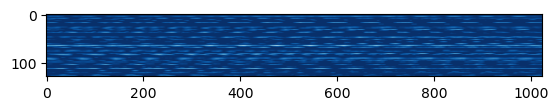

In [348]:
test_filter.resize_positional_encodings(1024)
test_filter.print_neighborhood_masks()

In [17]:

pos = generate_positional_encodings(encodings=encodings, type='independent')
print(f"Positional encodings shape: {pos.shape}")
print(f"Positional encodings:\n {pos}")
positional_encoding_shape = pos.shape
batch_size = 2
channels = 3
features = 4
filter_width = 5

embedding_size = math.floor((positional_encoding_shape[1] + features)/2)
embedding_size = max([embedding_size, positional_encoding_shape[1]])

Positional encodings shape: torch.Size([100, 100])
Positional encodings:
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [221]:
class PositionalParamKernel(nn.Module):  # currently doesnt work
    def __init__(
        self,
        positional_encoding_shape: tuple,
        features: int,
        channels: int,
        filter_width: int,
    ) -> None:
        super().__init__()

        self.positional_encoding_shape = positional_encoding_shape
        self.features = features
        self.channels = channels
        self.filter_width = filter_width

        self.parameter_factory = nn.Sequential(
            Debug_Module('parameter factory input'),
            nn.Linear(positional_encoding_shape[1], features * channels * filter_width, bias=False),
            nn.LeakyReLU(),
            nn.Unflatten(dim=1, unflattened_size=(features * channels, filter_width))
        )


    def forward(self, x, positional_encoding):

        print(f"Input shape: {x.shape}")
        print(f"Positional encoding shape: {positional_encoding.shape}")
        print(f"Positional encoding:\n {positional_encoding}")

        pos = positional_encoding.reshape(1, -1).repeat(x.shape[0], 1)

        print(f"Positional encoding shape: {pos.shape}")

        weights = self.parameter_factory(pos)

        print(f"Weights shape: {weights.shape}")
        print(f"Weights:\n {weights}")

        x[0] = torch.zeros(x[0].shape)

        print(f"Input shape: {x.shape}")
        print(f"Input:\n {x}")

        output = torch.matmul(x, weights)

        print(f"Output shape: {output.shape}")
        print(f"Output:\n {output}")

        return output


pos = generate_positional_encodings(encodings=encodings, type='independent')
print(f"Positional encodings shape: {pos.shape}")
print(f"Positional encodings:\n {pos}")
positional_encoding_shape = pos.shape
batch_size = 2
channels = 3
features = 4
filter_width = 5

test_vals = torch.randn(batch_size, channels, features)
test_vals

ker = PositionalParamKernel(
    positional_encoding_shape=positional_encoding_shape, 
    features=features, 
    channels=channels, 
    filter_width=filter_width
)

ker(
    nn.Flatten()(test_vals), 
    pos[0]
).reshape(batch_size, -1)

# pos[0].reshape(1, -1).shape

Positional encodings shape: torch.Size([64, 64])
Positional encodings:
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


NameError: name 'Debug_Module' is not defined

In [19]:
class PositionalMask(nn.Module):
    '''
        A differentiable mask that uses a positional encoding as input to find a mask
            
        This network does not take an input after configuration, but produces a positional encoding
            that can be used as input to a differential mask network
    '''

    types = ['independent', 'linear', 'circular']

    def __init__(
        self,
        masks: int = 32,
        size: int = 64,
        type: str = 'independent',
        config: dict = None,
        verbose: bool = False
    ):

        super().__init__()

        self.type = type
        self.masks = masks
        self.size = size
        self.verbose = verbose

        self.positional_encoding = None
        self.mask_input_shape = None

        if type not in self.types:
            raise ValueError(f"Positional mask type must be one of {self.types}")

        elif type == 'independent':
            # we produce a binary matrix of size (masks, masks) where the diagonal is all 1s and the rest are 0s
            #       this gives us a set of linearly independent vectors,
            #       meaning we train our mask to be a graph homomorphism taking unit vertices to the masking vertices 
            #       (i.e. the rows of the matrix)

            self.positional_encoding = torch.eye(masks, masks)
            self.mask_input_shape = (masks, masks)

        elif type == 'linear':
            # we produce a matrix of size (masks, 1) of the form [[0], [1/(m-1)], [2/(m-1)], ..., [1]]
            #       this gives us a set of points on the line from 0 to 1, 
            #       meaning we train our mask to be a path from 0 to 1

            self.positional_encoding = torch.arange(masks).reshape(-1, 1) / (masks - 1)
            self.mask_input_shape = (masks, 1)
            
        elif type == 'circular':
            # we produce a matrix of size (masks, 1) of the form [[0], [1/m], [2/m], ..., [(m-1)/m]]
            #       then we pass them through the unit circle function to get the circular encoding
            #       this finally gives us a matrix of size (masks, 2), 
            #       meaning we train our mask to be a loop parametrized by the unit circle

            pi = torch.tensor(math.pi)
            self.positional_encoding = torch.arange(masks).reshape(-1, 1) / masks
            self.positional_encoding = torch.cat((torch.cos(self.positional_encoding * 2 * pi), torch.sin(self.positional_encoding * 2 * pi)), dim=1)
            self.mask_input_shape = (masks, 2)


        self.differentiable_mask = DifferentiableMask(input_size=self.mask_input_shape[1], output_size=size, config=config)

        

    def forward(self, x):
        batch_size = x.shape[0]
        channels = x.shape[1]

        out: torch.Tensor = self.differentiable_mask(self.positional_encoding) 

        out = out.reshape(1, 1, -1)

        # we now duplicate the output for each batch and channel
        out = out.repeat(batch_size, channels, 1)


        return out




In [20]:
class DifferenceMask(nn.Module):
    '''
        A differentiable mask that uses a difference vector as input to find a mask

        The difference vector is calculated for each feature in the input vector
            by subtracting the vector of duplicates of that feature 


        input shape: (batch_size, channels, features)
        output shape: (batch_size, channels, features)
    '''

    def __init__(
        self,
        features: int = 64,
        channels: int = 4,
        config: dict = None,
        verbose: bool = False,
    ):
        super().__init__()

        self.differentiable_mask = DifferentiableMask(input_size=features * channels, output_size=features, config=config)


    def forward(self, x, i):
        batch_size, channels, features = x.shape

        

        y = x[:, :, i].reshape(batch_size, channels, 1).repeat(1, 1, features)
        x_hat = x - y

        # we can now calculate the sparse neighborhood of each feature in x
        #   by passing x_hat through self.differentiable_mask

        x_mask = self.differentiable_mask(x_hat.reshape(batch_size, -1)).reshape(batch_size, 1, -1)

        return x_mask.repeat(1, channels, 1)


    # def forward(self, x):

    #     batch_size, channels, features = x.shape

    #     y = torch.cat(tuple((x[:, :, i].reshape(batch_size, channels, 1).repeat(1, 1, features) for i in range(features))), dim=0)
    #     x = x.repeat(features, 1, 1)

    #     x_hat = x - y

    #     # we can now calculate the sparse neighborhood of each feature in x
    #     #   by passing x_hat through self.differentiable_mask

    #     x_mask = self.differentiable_mask(x_hat.reshape(batch_size * features, -1)).reshape(batch_size, 1, features)

    #     return x_mask.repeat(1, channels, 1)
        



class PositionalMask(nn.Module):
    '''
        A differentiable mask that uses a positional encoding as input to find a mask
            
        This network does not take an input after configuration, but produces a positional encoding
            that can be used as input to a differential mask network
    '''

    types = ['independent', 'linear', 'circular']

    def __init__(
        self,
        masks: int = 32,
        size: int = 64,
        type: str = 'independent',
        config: dict = None,
        verbose: bool = False
    ):

        super().__init__()

        self.type = type
        self.masks = masks
        self.size = size
        self.verbose = verbose

        self.positional_encoding = None
        self.mask_input_shape = None

        if type not in self.types:
            raise ValueError(f"Positional mask type must be one of {self.types}")

        elif type == 'independent':
            # we produce a binary matrix of size (masks, masks) where the diagonal is all 1s and the rest are 0s
            #       this gives us a set of linearly independent vectors,
            #       meaning we train our mask to be a graph homomorphism taking unit vertices to the masking vertices 
            #       (i.e. the rows of the matrix)

            self.positional_encoding = torch.eye(masks, masks)
            self.mask_input_shape = (masks, masks)

        elif type == 'linear':
            # we produce a matrix of size (masks, 1) of the form [[0], [1/(m-1)], [2/(m-1)], ..., [1]]
            #       this gives us a set of points on the line from 0 to 1, 
            #       meaning we train our mask to be a path from 0 to 1

            self.positional_encoding = torch.arange(masks).reshape(-1, 1) / (masks - 1)
            self.mask_input_shape = (masks, 1)
            
        elif type == 'circular':
            # we produce a matrix of size (masks, 1) of the form [[0], [1/m], [2/m], ..., [(m-1)/m]]
            #       then we pass them through the unit circle function to get the circular encoding
            #       this finally gives us a matrix of size (masks, 2), 
            #       meaning we train our mask to be a loop parametrized by the unit circle

            pi = torch.tensor(math.pi)
            self.positional_encoding = torch.arange(masks).reshape(-1, 1) / masks
            self.positional_encoding = torch.cat((torch.cos(self.positional_encoding * 2 * pi), torch.sin(self.positional_encoding * 2 * pi)), dim=1)
            self.mask_input_shape = (masks, 2)


        self.differentiable_mask = DifferentiableMask(input_size=self.mask_input_shape[1], output_size=size, config=config)

        

    def forward(self, x):
        batch_size = x.shape[0]
        channels = x.shape[1]

        out: torch.Tensor = self.differentiable_mask(self.positional_encoding) 

        out = out.reshape(1, 1, -1)

        # we now duplicate the output for each batch and channel
        out = out.repeat(batch_size, channels, 1)


        return out




In [21]:
class SparseDifferenceFilter(nn.Module):
    '''
        A convolutional filter that trains a neighborhood function in each filter to determine the neighborhood of each feature
        input shape: (batch_size, channels, features)
        output shape: (batch_size, filter_width, features)
    
    '''
    def __init__(
        self, 
        features = 62, 
        channels = 1,
        filter_width = 1,
        config: dict = None,
        verbose: bool = False
    ):
        super().__init__()

        self.in_size = features
        self.channels = channels
        self.filter_width = filter_width

        self.neighborhood = DifferenceMask(features=features, channels=channels, config=config, verbose=verbose)

        self.kernel = nn.Sequential(
            nn.Linear(features * channels, self.filter_width, bias=False),
        )

        self.flag: bool = verbose
        self.local_flag: bool = verbose

        
    def forward(self, x):
        if self.flag:
            print('initial shape:\t\t\t', x.shape)

        # Each feature has a sparse neighborhood we can calculate using self.sparse_neighborhood
        # output = torch.zeros(x.shape[0], self.filter_width, self.in_size)
        output = torch.zeros(x.shape[0], self.filter_width, 0)
        
        for i in range(x.shape[2]):

            mask = self.neighborhood(x, i)

            if self.local_flag:
                print('mask size: \t\t\t', mask.shape)
                print('mask contents:')
                print(mask)


            # we extract the sparse neighborhood of x_i from x
            xm = x * mask

            if self.local_flag:
                print('masked input:\t\t\t', xm.shape)
                print('masked input contents:')
                print(xm)

            # finally, we perform the convolution using the kernel on the sparse neighborhood of x_i
            output_i = self.kernel(xm.reshape(x.shape[0], -1)).reshape(x.shape[0], -1, 1)

            if self.local_flag:
                print('output:\t\t\t\t', output.shape)
                print('output_i:\t\t\t', output_i.shape)
                print('output_i contents:')
                print(output_i)

                self.local_flag = False

            # to finish, we concatenate the output for this x_i to the output tensor
            output = torch.cat((output, output_i), dim=2)

        if self.flag:
            print("post-run - sparse filter:\t", output.shape)
            self.flag = False

        return output



batch_size = 2
features = 4
channels = 5
filter_width = 3


test_vals = torch.randn(batch_size, channels, features)

test_filter = SparseDifferenceFilter(features=features, filter_width=filter_width, channels=channels, verbose=True)
print(f"Sparse filter with input shape {test_vals.shape} and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter(test_vals)

Sparse filter with input shape torch.Size([2, 5, 4]) and filter_width 3 has 164 parameters
initial shape:			 torch.Size([2, 5, 4])
mask size: 			 torch.Size([2, 5, 4])
mask contents:
tensor([[[0.0128, 0.2968, 0.0000, 0.6903],
         [0.0128, 0.2968, 0.0000, 0.6903],
         [0.0128, 0.2968, 0.0000, 0.6903],
         [0.0128, 0.2968, 0.0000, 0.6903],
         [0.0128, 0.2968, 0.0000, 0.6903]],

        [[0.0000, 0.0000, 0.1097, 0.8903],
         [0.0000, 0.0000, 0.1097, 0.8903],
         [0.0000, 0.0000, 0.1097, 0.8903],
         [0.0000, 0.0000, 0.1097, 0.8903],
         [0.0000, 0.0000, 0.1097, 0.8903]]], grad_fn=<RepeatBackward0>)
masked input:			 torch.Size([2, 5, 4])
masked input contents:
tensor([[[    -0.0141,     -0.4220,      0.0000,     -1.5090],
         [     0.0016,      0.1694,     -0.0000,      0.4389],
         [    -0.0238,     -0.0589,     -0.0000,     -0.9622],
         [     0.0004,      0.1021,     -0.0000,      0.9231],
         [     0.0001,      0.0556,      0

tensor([[[-0.1554, -0.1304,  0.0647, -0.1283],
         [-0.5270, -0.6020, -0.3957, -0.6060],
         [ 0.0875,  0.0556, -0.0613,  0.0533]],

        [[ 0.0992,  0.1361,  0.0073,  0.1453],
         [-0.3464, -0.1820, -0.3153, -0.3194],
         [-0.4093, -0.3680, -0.2423, -0.3748]]], grad_fn=<CatBackward0>)

In [325]:
class SparseFilter(nn.Module):
    '''
        A convolutional filter that trains a neighborhood function in each filter to determine the neighborhood of each feature
        input shape: (batch_size, channels, features)
        output shape: (batch_size, filter_width, features)
    
    '''
    def __init__(
        self, 
        features = 62, 
        channels = 1,
        filter_width = 1,
        config: dict = None,
        verbose: bool = False
    ):
        super().__init__()

        self.in_size = features
        self.channels = channels
        self.filter_width = filter_width

        self.sparse_neighborhood = nn.Sequential(
            nn.Linear(features * channels, features, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(features, features, bias=False),
            Sparsemax()
        )

        self.kernel = nn.Sequential(
            nn.Linear(features * channels, self.filter_width, bias=False),
        )

        self.flag: bool = verbose
        self.local_flag: bool = verbose

        
    def forward(self, x):
        if self.flag:
            print('initial shape:\t\t\t', x.shape)

        # Each feature has a sparse neighborhood we can calculate using self.sparse_neighborhood
        # output = torch.zeros(x.shape[0], self.filter_width, self.in_size)
        output = torch.zeros(x.shape[0], self.filter_width, 0)
        
        for i in range(x.shape[2]):

            # first, we extract a single feature x_i and duplicate + concatenate it to match the shape of x, giving us y
            y = torch.cat(tuple((x[:, :, i].reshape(-1, x.shape[1], 1) for _ in range(x.shape[2]))), dim=2)
            if self.local_flag:
                print('conv variable size:\t\t', y.shape, len(y))
            
            if self.local_flag:
                print('input size:\t\t\t', x.shape)


            # next, we calculate the sparse neighborhood of y
            nb = self.sparse_neighborhood((x - y).reshape(x.shape[0], -1))
            
            if self.local_flag:
                print("neighborhood:\t\t\t", nb.shape)
                print('neighborhood contents:')
                print(nb)

            # we create a mask of the same shape as x, but one that has the sparse neighborhood of x_i
            mask = torch.cat(tuple((nb.reshape(nb.shape[0], 1, -1) for _ in range(x.shape[1]))), dim=1)

            if self.local_flag:
                print('mask size: \t\t\t', mask.shape)
                # print('mask contents:')
                # print(mask)


            # we extract the sparse neighborhood of x_i from x
            xm = x * mask

            if self.local_flag:
                print('masked input:\t\t\t', xm.shape)
                print('masked input contents:')
                print(xm)

            # finally, we perform the convolution using the kernel on the sparse neighborhood of x_i
            output_i = self.kernel(xm.reshape(x.shape[0], -1)).reshape(x.shape[0], -1, 1)

            if self.local_flag:
                print('output:\t\t\t\t', output.shape)
                print('output_i:\t\t\t', output_i.shape)
                print('output_i contents:')
                print(output_i)

                self.local_flag = False

            # to finish, we concatenate the output for this x_i to the output tensor
            output = torch.cat((output, output_i), dim=2)

        if self.flag:
            print("post-run - sparse filter:\t", output.shape)
            self.flag = False

        return output



class SparseFilter1(nn.Module):
    '''
        A convolutional filter that trains a neighborhood function in each filter to determine the neighborhood of each feature
        input shape: (batch_size, channels, features)
        output shape: (batch_size, filter_width, features)
    
    '''
    def __init__(
        self, 
        features = 62, 
        channels = 1,
        filter_width = 1,
        config: dict = None,
        verbose: bool = False
    ):
        super().__init__()

        self.in_size = features
        self.channels = channels
        self.filter_width = filter_width

        self.neighborhood = DifferenceMask()

        self.kernel = nn.Sequential(
            nn.Linear(features * channels, self.filter_width, bias=False),
        )

        self.flag: bool = verbose
        self.local_flag: bool = verbose

        
    def forward(self, x):
        if self.flag:
            print('initial shape:\t\t\t', x.shape)

        # Each feature has a sparse neighborhood we can calculate using self.sparse_neighborhood
        # output = torch.zeros(x.shape[0], self.filter_width, self.in_size)
        output = torch.zeros(x.shape[0], self.filter_width, 0)
        
        for i in range(x.shape[2]):

            mask = self.neighborhood(x, i)

            if self.local_flag:
                print('mask size: \t\t\t', mask.shape)
                # print('mask contents:')
                # print(mask)


            # we extract the sparse neighborhood of x_i from x
            xm = x * mask

            if self.local_flag:
                print('masked input:\t\t\t', xm.shape)
                print('masked input contents:')
                print(xm)

            # finally, we perform the convolution using the kernel on the sparse neighborhood of x_i
            output_i = self.kernel(xm.reshape(x.shape[0], -1)).reshape(x.shape[0], -1, 1)

            if self.local_flag:
                print('output:\t\t\t\t', output.shape)
                print('output_i:\t\t\t', output_i.shape)
                print('output_i contents:')
                print(output_i)

                self.local_flag = False

            # to finish, we concatenate the output for this x_i to the output tensor
            output = torch.cat((output, output_i), dim=2)

        if self.flag:
            print("post-run - sparse filter:\t", output.shape)
            self.flag = False

        return output



batch_size = 2
features = 4
channels = 5
filter_width = 3


test_vals = torch.randn(batch_size, channels, features)

test_filter = SparseFilter1(features=features, filter_width=filter_width, channels=channels, verbose=True)
print(f"Sparse filter with input shape {test_vals.shape} and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter(test_vals)

NameError: name 'DifferenceMask' is not defined

In [23]:
class SparsePositionalEmbeddingConvolution(nn.Module):
    '''
        A convolutional layer that trains a neighborhood function in each filter to determine the neighborhood of each feature
        input shape: (batch_size, channels, features)
        output shape: (batch_size, filters * filter_width, features)
    '''
    def __init__(
        self, 
        features = 62, 
        channels = 1,
        filters = 1,
        filter_width = 1,
        num_encodings = 5,
        positional_type = 'independent',
        config: dict = None,
        verbose: bool = False
    ):
        super().__init__()

        self.in_size = features
        self.channels = channels
        self.num_filters = filters
        self.filter_width = filter_width

        self.filters = nn.ModuleList([
            SparsePositionalEmbeddingFilter(
                features=features, 
                channels=channels, 
                filter_width=filter_width,
                num_encodings=num_encodings,
                positional_type=positional_type,
                verbose=verbose
            )
            for _ in range(filters)
        ])

        self.flag: bool = verbose
        self.local_flag: bool = verbose

        
    def forward(self, x):
        if self.flag:
            print('initial shape:\t\t\t', x.shape)

        # We run each filter on the input in parallel
        output = torch.cat(tuple((filter(x) for filter in self.filters)), dim=1)


        if self.flag:
            print("post-run - sparse conv:\t", output.shape)
            self.flag = False

        return output




batch_size = 2
features = 4
channels = 2
filter_width = 3
filters = 2
num_encodings = 64


test_vals = torch.randn(batch_size, channels, features)

test_filter = SparsePositionalEmbeddingConvolution(
    features=features, 
    channels=channels, 
    filters=filters, 
    filter_width=filter_width, 
    num_encodings=num_encodings,
    verbose=True
)
print(f"Sparse filter with input shape {test_vals.shape} and filter_width {filter_width} has {sum(p.numel() for p in test_filter.parameters())} parameters")
test_filter(test_vals)

Sparse filter with input shape torch.Size([2, 2, 4]) and filter_width 3 has 1144 parameters
initial shape:			 torch.Size([2, 2, 4])
Input shape: torch.Size([2, 2, 4])
features: 4
channels: 2
filter_width: 3
num_encodings: 64
Positional Encodings shape: torch.Size([64, 64])
Mask shape: torch.Size([64, 4])
Neighborhood shape: torch.Size([2, 2, 4])
Output shape: torch.Size([2, 3, 1])
Final output shape: torch.Size([2, 3, 64])
Input shape: torch.Size([2, 2, 4])
features: 4
channels: 2
filter_width: 3
num_encodings: 64
Positional Encodings shape: torch.Size([64, 64])
Mask shape: torch.Size([64, 4])
Neighborhood shape: torch.Size([2, 2, 4])
Output shape: torch.Size([2, 3, 1])
Final output shape: torch.Size([2, 3, 64])
post-run - sparse conv:	 torch.Size([2, 6, 64])


tensor([[[ 0.3796,  0.3663,  0.3767,  0.4395,  0.4265,  0.3846,  0.4026,
           0.4471,  0.3673,  0.4443,  0.4004,  0.3918,  0.3756,  0.3927,
           0.4500,  0.3612,  0.3962,  0.3579,  0.4056,  0.3776,  0.3675,
           0.3669,  0.4069,  0.4480,  0.3852,  0.3936,  0.4073,  0.4435,
           0.4298,  0.3911,  0.3745,  0.3884,  0.3729,  0.4415,  0.4274,
           0.4377,  0.4382,  0.4057,  0.4405,  0.3816,  0.4236,  0.4218,
           0.4371,  0.4513,  0.3889,  0.3851,  0.4730,  0.3845,  0.4065,
           0.4245,  0.4406,  0.4389,  0.3450,  0.4474,  0.4173,  0.3716,
           0.4420,  0.3549,  0.3833,  0.3460,  0.4161,  0.4539,  0.3856,
           0.3991],
         [-0.1624, -0.1593, -0.1473, -0.1485, -0.1411, -0.1397, -0.1528,
          -0.1362, -0.1835, -0.1172, -0.1705, -0.1684, -0.1654, -0.1611,
          -0.1404, -0.1567, -0.1670, -0.1750, -0.1762, -0.1774, -0.1852,
          -0.1817, -0.1727, -0.1527, -0.1433, -0.1738, -0.1525, -0.1413,
          -0.1497, -0.1563, -0.

In [24]:
class SparsePositionalEmbeddingCNN(nn.Module):
    def __init__(self, input_features = 64, output_features = 8, channels: int = 1, device = 'cpu', verbose: bool = False, config: dict = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 5,
                'num_encodings': 64,
                'positional_type': 'independent',
                'pool_size': 32
            },
        ],

        'fc_layers': [
            100 for _ in range(3)
        ]
    }):
        super().__init__()

        self.input_features = input_features
        self.channels = channels
        self.output_features = output_features

        conv_layers = []
        pool_layers = []

        last_output_features = input_features

        if 'verbose' in config:
            verbose = config['verbose']

        for i, layer in enumerate(config['conv_layers']):

            features = last_output_features            

            conv_layers.append(
                SparsePositionalEmbeddingConvolution(
                    features=features, 
                    channels=channels,
                    filters=layer['filters'], 
                    filter_width=layer['filter_width'],
                    num_encodings=layer['num_encodings'],
                    positional_type=layer['positional_type'],
                    verbose=verbose
                )
            )

            channels = layer['filters'] * layer['filter_width']

            if 'pool_size' in layer:
                pool_layers.append(
                    nn.AdaptiveMaxPool1d(layer['pool_size'])
                )

                last_output_features = layer['pool_size']

            else:
                pool_layers.append(None)

                last_output_features = layer['num_encodings']

        layers = []

        for i, layer in enumerate(conv_layers):
            channels = layer.num_filters * layer.filter_width
            layers.append(layer)

            layers.append(
                nn.LeakyReLU()
            )

            layers.append(
                nn.GroupNorm(channels, channels)
            )

            if pool_layers[i] is not None:
                layers.append(pool_layers[i])


        head_input_size = conv_layers[-1].num_filters * conv_layers[-1].filter_width * last_output_features

        fc_layers = []
        if 'fc_layers' in config and len(config['fc_layers']) > 0:
            for i, layer in enumerate(config['fc_layers']):
                size = head_input_size if i == 0 else config['fc_layers'][i-1]

                fc_layers.extend([
                    nn.Linear(size, layer),
                    nn.ReLU()
                ])

            fc_layers.append(
                nn.Linear(config['fc_layers'][-1], output_features)
            )
        
        else:
            fc_layers.append(
                nn.Linear(head_input_size, output_features)
            )

        self.head = nn.Sequential(
            *layers,
            Debug_Module('pre-flatten'),
            nn.Flatten(),
            Debug_Module('post-flatten'),
            *fc_layers
            # nn.Linear(conv_layers[-1].num_filters * conv_layers[-1].filter_width * last_output_features, output_features)
        )

        self.flag: bool = True


    def forward(self, x):
        if self.flag:
            print('Pre-run: simple_model -', x.shape)

        if len(x.shape) == 2:
            x = x.reshape(x.shape[0], 1, -1)

            if self.flag:
                print("reshaped: simple_model -", x.shape)

        x = self.head(x)

        if self.flag:
            print('Post-run: simple_model -', x.shape)
            self.flag = False

        # raise Exception('stop')
        return x


In [25]:
    


batch_size = 64
features = 64
channels = 1
filter_width = 3
filters = 2
num_encodings = 3

if channels == 1:
    test_vals = torch.randn(batch_size, features)
else:
    test_vals = torch.randn(batch_size, channels, features)


test_cnn = SparsePositionalEmbeddingCNN(
    input_features=features,
    channels=channels,
    output_features=8,
    config = {
        'conv_layers': [
            # {
            #     'filters': 3,
            #     'filter_width': 2,
            #     'num_encodings': 64,
            #     'positional_type': 'independent',
            #     'pool_size': 32
            # },
            {
                'filters': 1,
                'filter_width': 5,
                'num_encodings': 128,
                'positional_type': 'independent',
                # 'positional_type': 'linear',
                'pool_size': 64
            }
        ],
        # 'fc_layers': [
        #     100 for _ in range(3)
        # ]
    },
    verbose=True
)

print(f"Sparse CNN with input shape {test_vals.shape} and filter_width {filter_width} has {sum(p.numel() for p in test_cnn.parameters())} parameters")

test_cnn(test_vals)

Sparse CNN with input shape torch.Size([64, 64]) and filter_width 3 has 16644 parameters
Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
initial shape:			 torch.Size([64, 1, 64])
Input shape: torch.Size([64, 1, 64])
features: 64
channels: 1
filter_width: 5
num_encodings: 128
Positional Encodings shape: torch.Size([128, 128])
Mask shape: torch.Size([128, 64])
Neighborhood shape: torch.Size([64, 1, 64])
Output shape: torch.Size([64, 5, 1])
Final output shape: torch.Size([64, 5, 128])
post-run - sparse conv:	 torch.Size([64, 5, 128])
pre-flatten - torch.Size([64, 5, 64])
post-flatten - torch.Size([64, 320])
Post-run: simple_model - torch.Size([64, 8])


tensor([[    -0.6253,      0.5701,     -0.2373,     -0.6099,      0.1333,
             -0.8767,      0.2125,     -0.4758],
        [    -0.4492,      0.1243,     -0.4862,     -0.8092,     -0.1348,
             -0.4988,     -0.6001,     -0.6178],
        [    -1.6410,      0.2941,     -0.2606,     -0.2544,     -0.6725,
             -0.4350,      0.1847,     -0.3344],
        [    -0.7941,      0.4925,      0.0061,     -0.0988,     -1.0783,
              0.5340,      0.2718,     -0.3785],
        [    -1.1631,      0.1368,     -0.8148,     -0.4731,     -0.6283,
             -0.3005,     -0.5557,     -0.3189],
        [    -0.7910,      1.2309,     -0.4703,     -0.6027,     -0.6473,
             -0.3328,      0.2165,      0.0351],
        [    -0.8862,      0.4203,     -0.5509,     -0.8109,     -0.4603,
             -0.5840,     -0.1504,     -0.7132],
        [    -1.0292,      0.1581,     -0.5676,     -0.5150,     -0.2865,
             -0.1714,      0.4872,     -0.1790],
        [    -0.

Shape of Input Data: (11762, 63)
Parameters in the model: 32092


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 2, 32])
post-flatten - torch.Size([64, 64])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.981242,1.957708,0.448554,0.146521,0.626288,0.131131,0.115740,0.105683,0.146521,00:05
1,1.891384,1.843871,0.438350,0.138670,0.656484,0.109320,0.101482,0.097839,0.138670,00:04
2,1.736632,1.674402,0.434524,0.136820,0.647753,0.100196,0.098499,0.096018,0.136820,00:04
3,1.563283,1.503810,0.441752,0.143671,0.656368,0.119365,0.111892,0.218726,0.143671,00:04
4,1.442278,1.407436,0.510204,0.210959,0.689089,0.297546,0.197413,0.247470,0.210959,00:04
5,1.387580,1.332375,0.517007,0.216282,0.716040,0.283725,0.204578,0.227773,0.216282,00:04
6,1.296404,1.246863,0.624575,0.270275,0.733687,0.448184,0.255565,0.250036,0.270275,00:04
7,1.217465,1.188234,0.618622,0.270833,0.753738,0.444468,0.255698,0.251039,0.270833,00:04
8,1.176146,1.161739,0.622449,0.270294,0.764337,0.450619,0.259039,0.265613,0.270294,00:04
9,1.182760,1.139767,0.630952,0.276301,0.767442,0.466846,0.261957,0.261604,0.276301,00:04


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


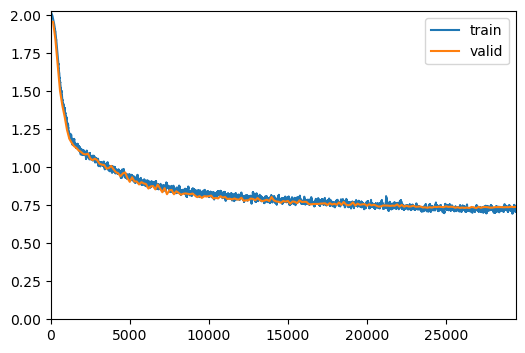

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.7397585511207581, accuracy:  75.26%


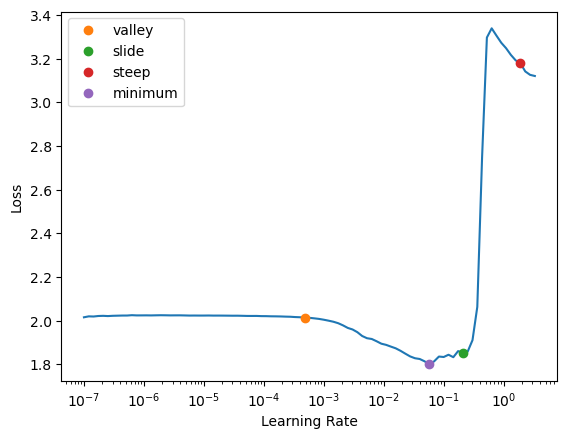

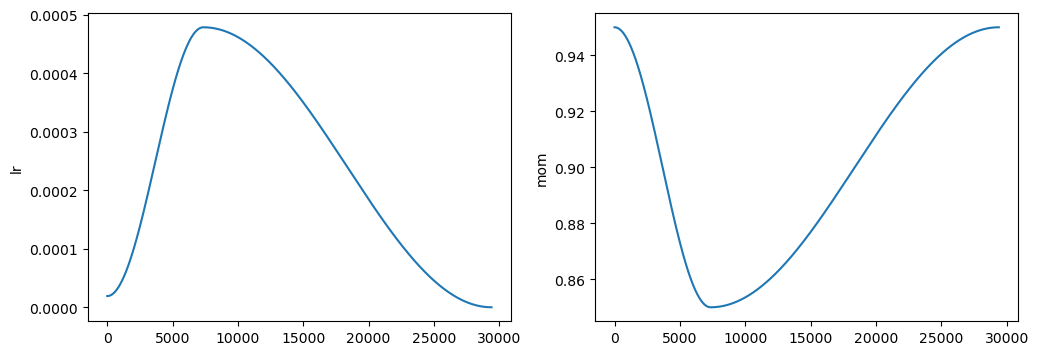

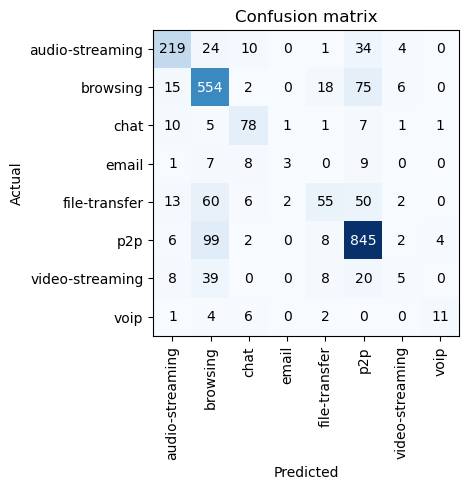

In [26]:
results_sparse_pe_cnn_1 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 2,
                'num_encodings': 64,
                'positional_type': 'linear',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 5104


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 2, 32])
post-flatten - torch.Size([64, 64])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.679398,1.529355,0.455782,0.206294,0.640413,0.188128,0.198647,0.197604,0.206294,00:03
1,1.443042,1.375538,0.510629,0.218156,0.677730,0.312610,0.192956,0.358024,0.218156,00:03
2,1.381796,1.335343,0.528912,0.225555,0.706825,0.319158,0.206100,0.226037,0.225555,00:03
3,1.319064,1.285552,0.541667,0.231552,0.730216,0.323172,0.213393,0.213398,0.231552,00:03
4,1.307696,1.260438,0.613095,0.262724,0.725232,0.432610,0.247230,0.242153,0.262724,00:03
5,1.258058,1.229985,0.629252,0.270271,0.727767,0.456091,0.254777,0.248276,0.270271,00:03
6,1.244620,1.208108,0.626276,0.274024,0.736500,0.455215,0.250536,0.234693,0.274024,00:03
7,1.219530,1.167602,0.635629,0.287209,0.758452,0.476398,0.266496,0.356512,0.287209,00:03
8,1.202255,1.156996,0.632653,0.287338,0.755624,0.472690,0.268372,0.349997,0.287338,00:03
9,1.175346,1.151910,0.645833,0.293522,0.756670,0.491217,0.274019,0.352763,0.293522,00:03


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


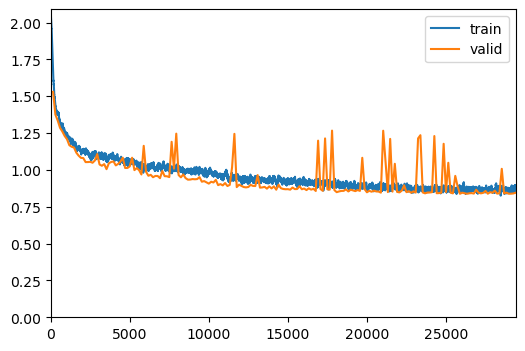

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.8451949954032898, accuracy:  73.13%


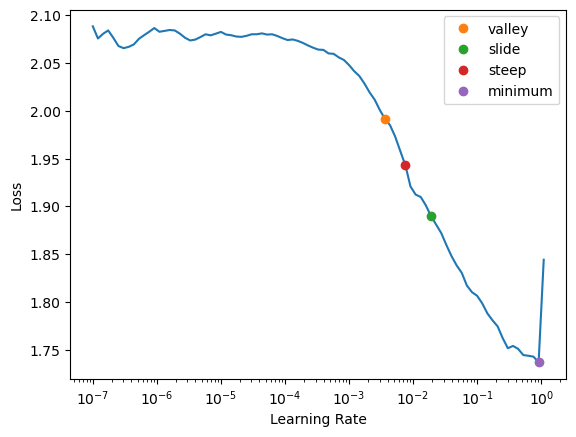

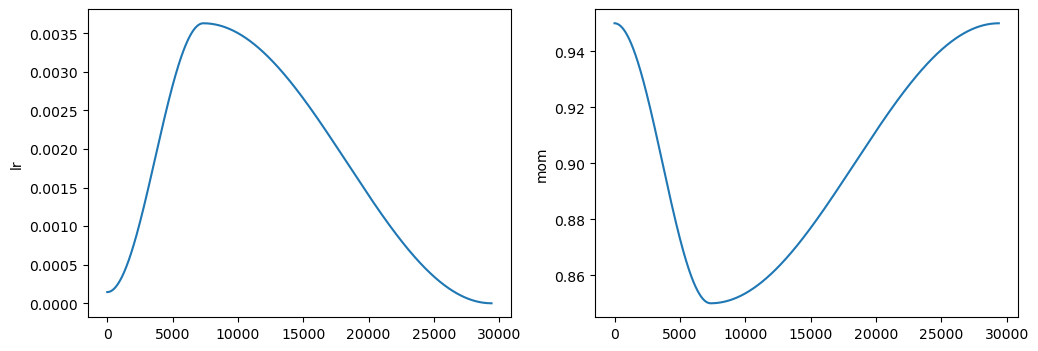

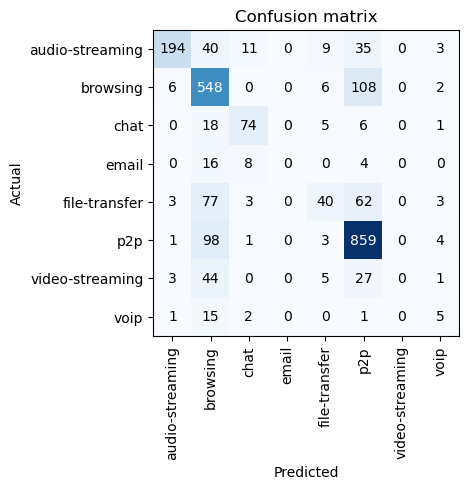

In [27]:
results_sparse_pe_cnn_2 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 2,
                'num_encodings': 64,
                'positional_type': 'linear',
                'pool_size': 32
            },
        ],
        # 'fc_layers': [
        #     100 for _ in range(3)
        # ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 7096


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.707039,1.595939,0.412840,0.141717,0.608123,0.065237,0.120059,0.147489,0.141717,00:04
1,1.516764,1.458110,0.451956,0.180868,0.659593,0.150403,0.180722,0.356808,0.180868,00:04
2,1.401997,1.359155,0.467687,0.205173,0.707844,0.186924,0.203318,0.346042,0.205173,00:04
3,1.314748,1.268427,0.633503,0.273268,0.746640,0.460963,0.261111,0.299398,0.273268,00:04
4,1.229823,1.190864,0.625000,0.269814,0.782704,0.447592,0.256298,0.252440,0.269814,00:04
5,1.176236,1.150801,0.629252,0.271794,0.798220,0.454513,0.257345,0.251942,0.271794,00:04
6,1.152448,1.120321,0.628827,0.271893,0.803657,0.454264,0.256808,0.250176,0.271893,00:04
7,1.128032,1.092483,0.637330,0.284042,0.809137,0.468085,0.279653,0.379029,0.284042,00:04
8,1.096423,1.064770,0.641156,0.288141,0.814245,0.475631,0.284641,0.360158,0.288141,00:04
9,1.088937,1.048748,0.641156,0.288141,0.824120,0.475844,0.284587,0.345877,0.288141,00:04


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


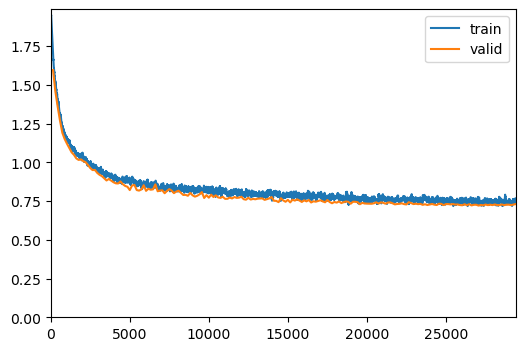

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.7306472063064575, accuracy:  75.43%


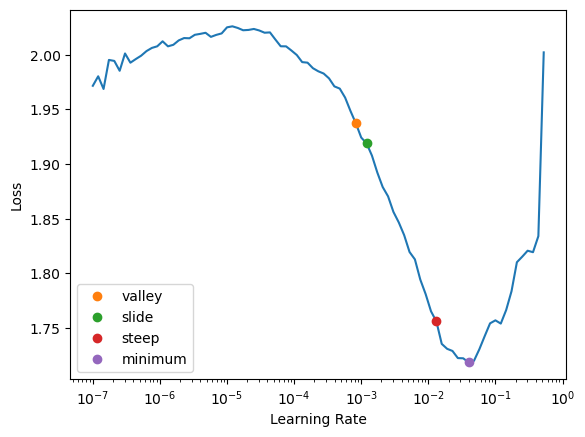

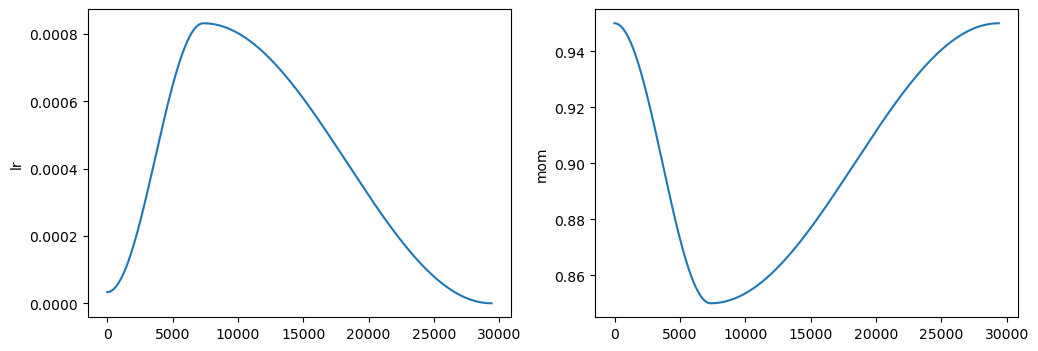

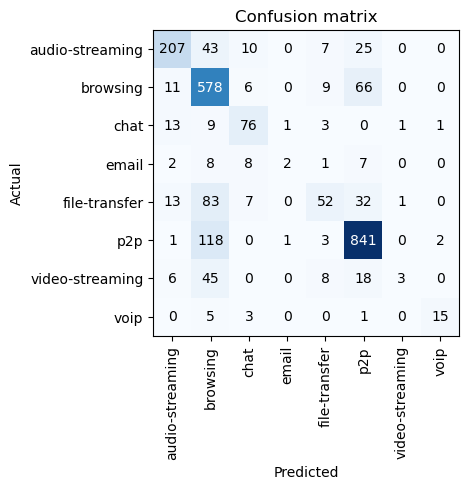

In [28]:
results_sparse_pe_cnn_3 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 8,
                'num_encodings': 64,
                'positional_type': 'linear',
                'pool_size': 32
            },
        ],
        # 'fc_layers': [
        #     100 for _ in range(3)
        # ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 51748


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,2.041630,2.017307,0.410714,0.125000,0.572659,0.000000,0.072785,0.051339,0.125000,00:05
1,1.934581,1.879588,0.410714,0.125000,0.592353,0.000000,0.072785,0.051339,0.125000,00:05
2,1.742900,1.663518,0.410714,0.125000,0.627465,0.000000,0.072785,0.051339,0.125000,00:05
3,1.567194,1.513536,0.410714,0.125000,0.644423,0.000000,0.072785,0.051339,0.125000,00:05
4,1.483297,1.443196,0.484269,0.199357,0.656847,0.294043,0.167051,0.169126,0.199357,00:05
5,1.413080,1.378609,0.494473,0.207457,0.678067,0.304580,0.172329,0.230307,0.207457,00:05
6,1.381785,1.339705,0.502551,0.211415,0.707773,0.311645,0.179954,0.239347,0.211415,00:05
7,1.360330,1.318416,0.501276,0.210798,0.720387,0.312189,0.178976,0.243964,0.210798,00:05
8,1.350559,1.297941,0.515306,0.218327,0.730498,0.316823,0.196764,0.245684,0.218327,00:05
9,1.307897,1.273172,0.512755,0.217150,0.742450,0.312558,0.194081,0.241337,0.217150,00:04


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


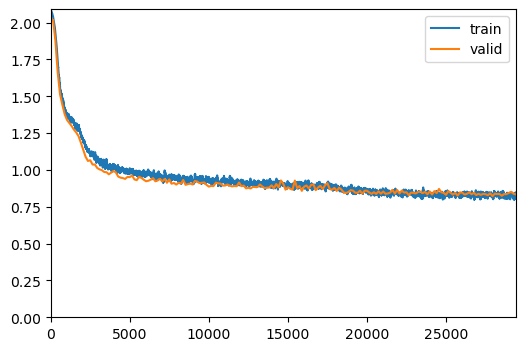

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.834481954574585, accuracy:  72.19%


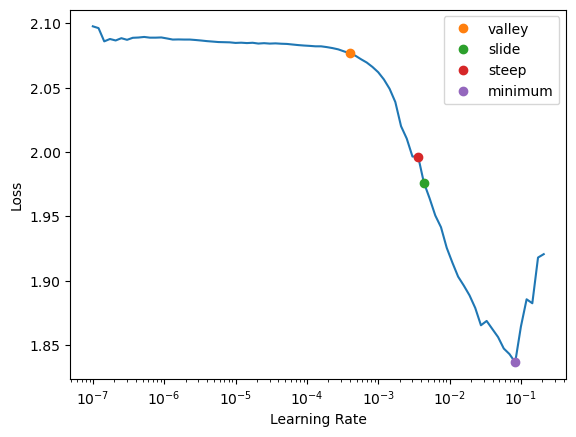

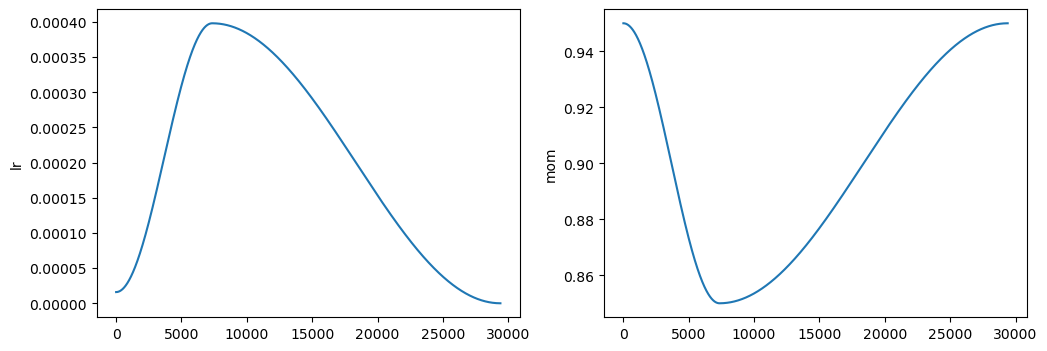

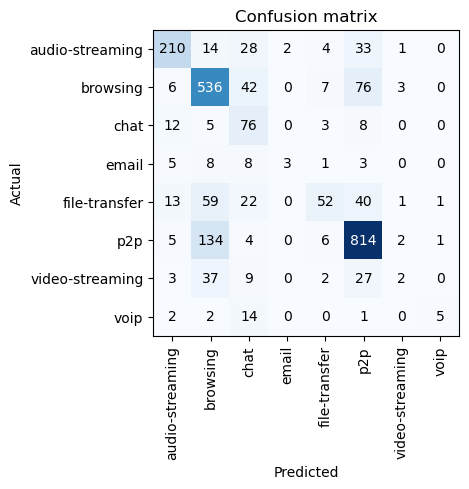

In [29]:
results_sparse_pe_cnn_4 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 1,
                'filter_width': 8,
                'num_encodings': 64,
                'positional_type': 'linear',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 56046


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.734505,1.545535,0.411565,0.125373,0.649341,0.027255,0.076103,0.056170,0.125373,00:07
1,1.457383,1.380940,0.487670,0.202540,0.716147,0.267661,0.174320,0.181695,0.202540,00:07
2,1.325781,1.256453,0.551446,0.237412,0.760417,0.344033,0.214252,0.210188,0.237412,00:07
3,1.192355,1.135549,0.630102,0.277244,0.791619,0.461380,0.252155,0.231595,0.277244,00:08
4,1.124368,1.062873,0.635204,0.279292,0.817274,0.468649,0.253795,0.232777,0.279292,00:07
5,1.060065,1.011846,0.685799,0.382325,0.831974,0.551233,0.381773,0.480081,0.382325,00:09
6,1.013981,0.975272,0.700680,0.390449,0.841330,0.577974,0.390260,0.477316,0.390449,00:09
7,0.971163,0.939897,0.689626,0.383579,0.843894,0.553565,0.385581,0.458538,0.383579,00:09
8,0.956614,0.908175,0.721514,0.400232,0.846100,0.607196,0.399199,0.439273,0.400232,00:09
9,0.930192,0.908766,0.718963,0.398780,0.850018,0.605630,0.396852,0.432863,0.398780,00:08


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


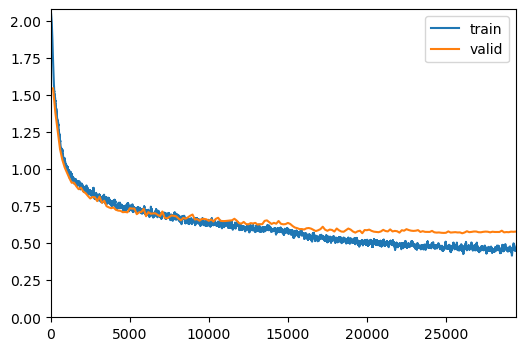

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5783737897872925, accuracy:  82.57%


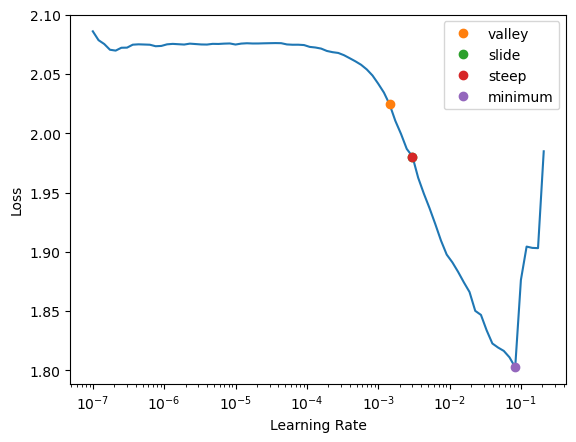

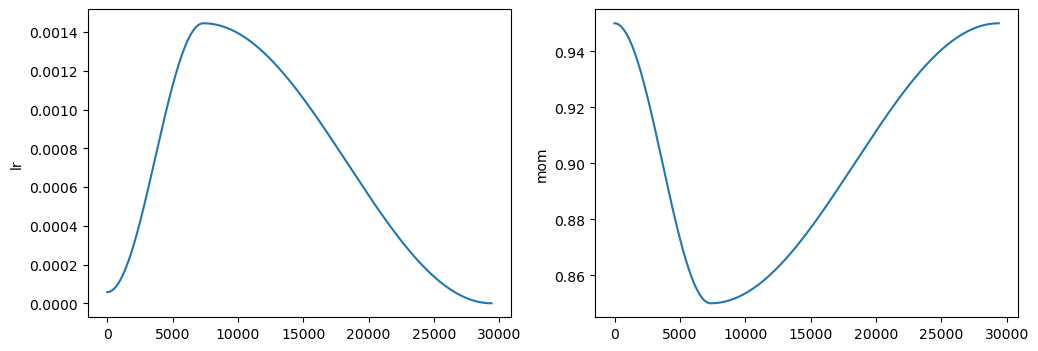

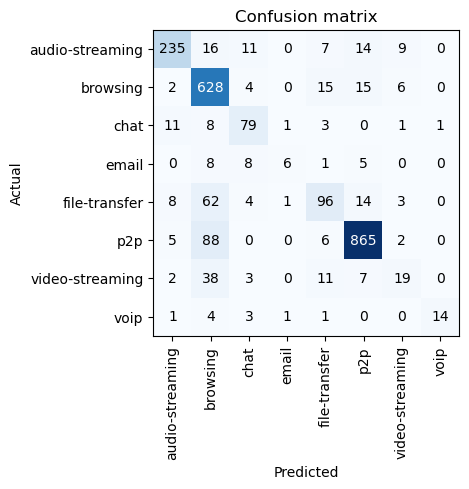

In [30]:
results_sparse_pe_cnn_5 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 2,
                'filter_width': 4,
                'num_encodings': 64,
                'positional_type': 'linear',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 56046


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,2.024490,2.002000,0.284864,0.125000,0.601168,0.000000,0.055427,0.035608,0.125000,00:15
1,1.924499,1.875217,0.343963,0.140643,0.642748,0.129229,0.093902,0.133276,0.140643,00:15
2,1.757144,1.686963,0.420493,0.131235,0.635388,0.063112,0.091603,0.082345,0.131235,00:14
3,1.580610,1.520554,0.411565,0.125373,0.659606,0.027255,0.076103,0.056170,0.125373,00:14
4,1.491251,1.450641,0.411565,0.125373,0.690188,0.031643,0.077240,0.056760,0.125373,00:15
5,1.424039,1.396234,0.481718,0.196305,0.705462,0.249142,0.170161,0.184608,0.196305,00:14
6,1.378001,1.343894,0.494473,0.208543,0.735450,0.267772,0.174707,0.177474,0.208543,00:15
7,1.326116,1.284691,0.546769,0.234973,0.753718,0.339823,0.212019,0.213257,0.234973,00:15
8,1.260510,1.222598,0.554847,0.240773,0.774028,0.346942,0.217036,0.207903,0.240773,00:14
9,1.214178,1.162836,0.626276,0.275133,0.790681,0.454422,0.250188,0.229686,0.275133,00:14


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


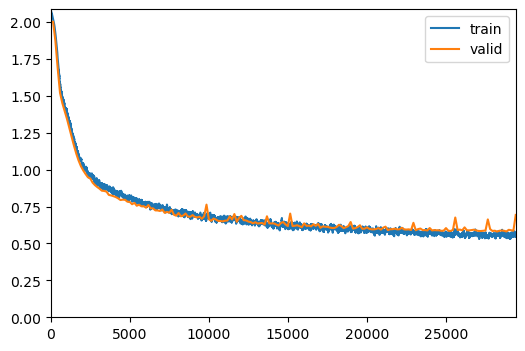

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.6934449672698975, accuracy:  78.49%


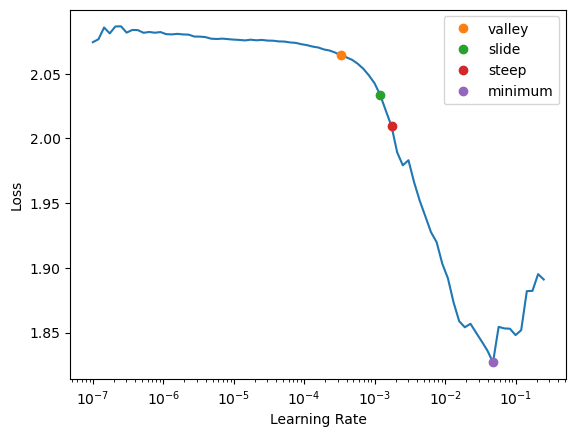

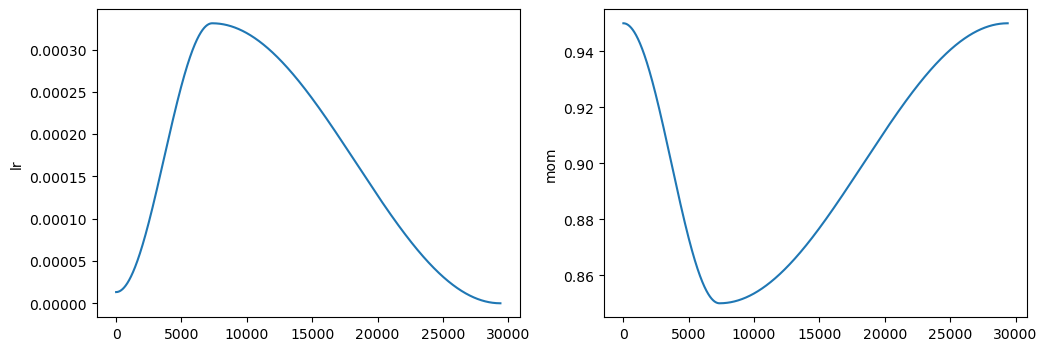

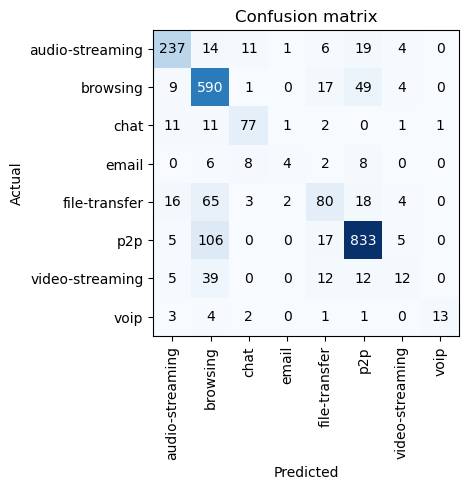

In [31]:
results_sparse_pe_cnn_6 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 2,
                'filter_width': 4,
                'num_encodings': 128,
                'positional_type': 'linear',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 56046


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.868385,1.734447,0.390731,0.124463,0.647677,0.015980,0.093851,0.079362,0.124463,00:22
1,1.526234,1.440373,0.411565,0.125373,0.688082,0.032407,0.077453,0.056912,0.125373,00:21
2,1.403748,1.353529,0.491922,0.207062,0.717536,0.293300,0.163364,0.143823,0.207062,00:21
3,1.321620,1.268006,0.549745,0.236749,0.759598,0.346565,0.212339,0.213933,0.236749,00:21
4,1.216488,1.173378,0.621173,0.271922,0.788428,0.446374,0.247425,0.228061,0.271922,00:22
5,1.143715,1.094082,0.638180,0.280871,0.805925,0.474568,0.254781,0.233457,0.280871,00:22
6,1.079344,1.034504,0.664966,0.333907,0.825958,0.517971,0.331828,0.358299,0.333907,00:22
7,1.033008,0.986128,0.676871,0.370477,0.834973,0.537210,0.362101,0.363808,0.370477,00:22
8,0.986252,0.948198,0.692602,0.384639,0.842915,0.561455,0.381567,0.488764,0.384639,00:22
9,0.962396,0.917271,0.718963,0.397209,0.841288,0.602712,0.392304,0.467215,0.397209,00:22


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


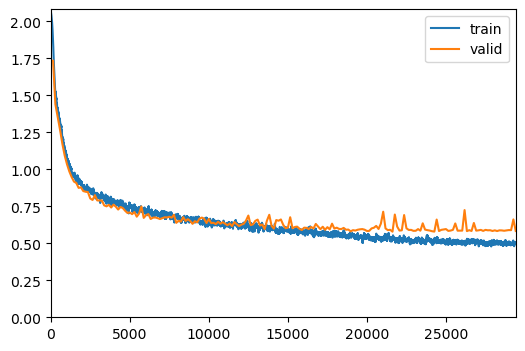

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5835686922073364, accuracy:  81.63%


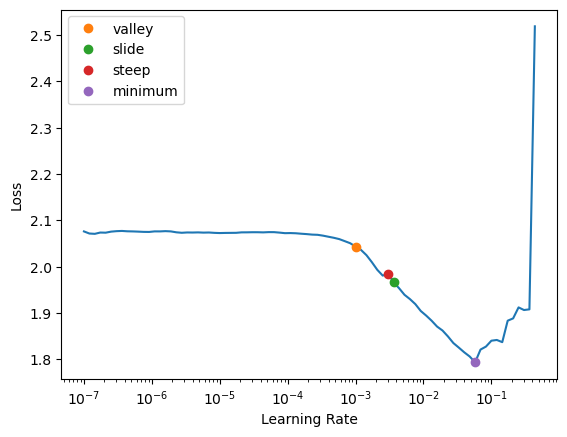

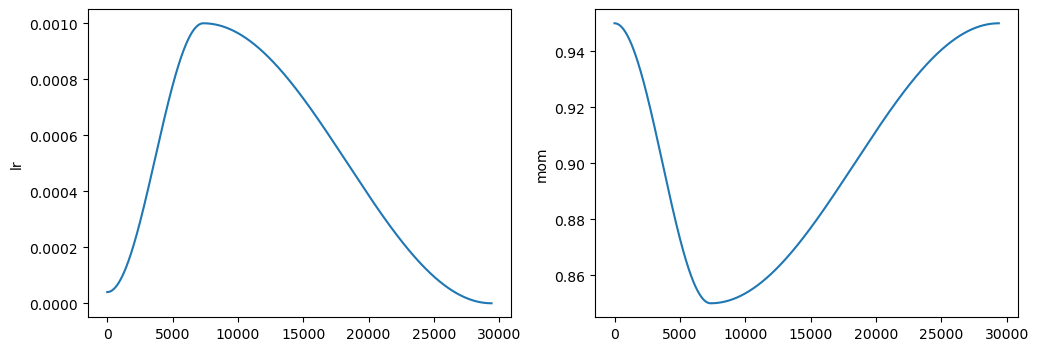

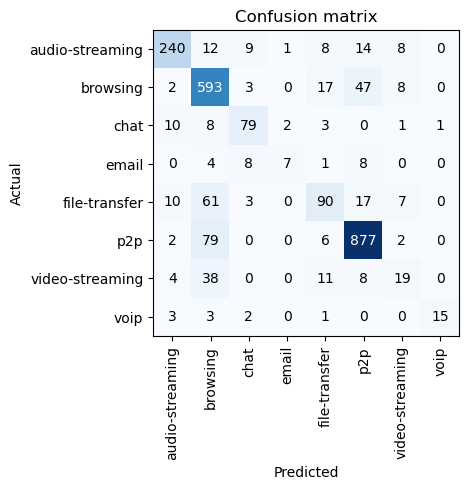

In [32]:
results_sparse_pe_cnn_7 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 2,
                'filter_width': 4,
                'num_encodings': 256,
                'positional_type': 'linear',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

Shape of Input Data: (11762, 63)
Parameters in the model: 56046


Pre-run: simple_model - torch.Size([64, 64])
reshaped: simple_model - torch.Size([64, 1, 64])
pre-flatten - torch.Size([64, 8, 32])
post-flatten - torch.Size([64, 256])
Post-run: simple_model - torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.955250,1.879239,0.346088,0.141461,0.652395,0.138022,0.094669,0.137397,0.141461,00:38
1,1.654153,1.536307,0.411139,0.125244,0.661335,0.025838,0.076071,0.056127,0.125244,00:38
2,1.470456,1.415910,0.440901,0.153277,0.710527,0.131124,0.124549,0.189643,0.153277,00:38
3,1.385332,1.338635,0.505952,0.212703,0.739944,0.270520,0.194177,0.210134,0.212703,00:38
4,1.294912,1.245765,0.568452,0.245657,0.757795,0.366031,0.225826,0.219182,0.245657,00:38
5,1.206255,1.157583,0.625000,0.273932,0.779681,0.450223,0.253313,0.237414,0.273932,00:38
6,1.150622,1.109843,0.634779,0.277867,0.796613,0.465552,0.257583,0.242520,0.277867,00:37
7,1.104518,1.059066,0.655612,0.340441,0.815384,0.500436,0.341637,0.357526,0.340441,00:38
8,1.072227,1.026565,0.675170,0.367154,0.824907,0.533441,0.362490,0.368904,0.367154,00:38
9,1.043051,0.992029,0.684524,0.383411,0.833114,0.547364,0.382525,0.474020,0.383411,00:38


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


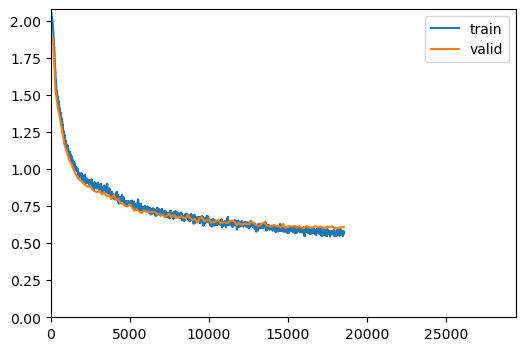

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

In [33]:
results_sparse_pe_cnn_8 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    SparsePositionalEmbeddingCNN, 
    config = {
        'conv_layers': [
            {
                'filters': 2,
                'filter_width': 4,
                'num_encodings': 512,
                'positional_type': 'linear',
                'pool_size': 32
            },
        ],
        'fc_layers': [
            100 for _ in range(3)
        ]
    },
    epochs=200
)

In [ ]:
results_simple_filter.model.model.model

In [ ]:

model_1 = results.model.model.model
model_2 = results_res.model.model.model
model_3 = results_simple_res.model.model.model
model_4 = results_simple_filter.model.model.model

print(f"Deep NN 50x10 has {sum(p.numel() for p in model_1.parameters())} parameters")
print(f"Deep Res NN 50x10 has {sum(p.numel() for p in model_2.parameters())} parameters")
print(f"Simple Res NN 50x10 has {sum(p.numel() for p in model_3.parameters())} parameters")
print(f"Sparse CNN 1 filter has {sum(p.numel() for p in model_4.parameters())} parameters")

In [ ]:


class Simple_Model(nn.Module):
    def __init__(self, input_features=62, output_features=8, config: dict = None):
        super().__init__()

        self.out = nn.Sequential(
            nn.Linear(input_features, 105, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(105, 105, bias=False),
            nn.ReLU(inplace=True),

            nn.Linear(105, output_features+1)
        )

        self.flag: bool = True

        
    def forward(self, x):

        if self.flag:
            print(x.shape)

        x = self.out(x)

        if self.flag:
            print(x.shape)
            self.flag = False

        return x

results_t_res = run_torch_nn_experiment(df.drop(['Traffic Type'], axis=1), dataset_1['File'], 'Application Type', Simple_Model)


In [ ]:
from fastai.layers import SimpleCNN
from fastai.vision.all import resnet50

In [ ]:
res_model = resnet50(pretrained=True)

In [ ]:
SimpleCNN([1,8,8])

In [ ]:
res_model

In [ ]:
class Flow_Wrapping_2D_CNN(nn.Module):
    def __init__(self, input_features=62, output_features=8, config: dict = None):
        super().__init__()

        self.input_features = input_features
        self.output_features = output_features
        self.config = config

        self.lgi = self.find_least_greatest_int()

        self.out = nn.Sequential(
            SimpleCNN([1,8,8]),
        )

    
    def find_least_greatest_int(self) -> int:
        ''' 
            This method will find the least greatest int z such that
                z^2 >= input_features
        '''

        z = 1

        while(z**2 < self.input_features):
            z += 1

        return z

    def resphape_input(self, x):
        '''
            This method will return the new shape for the input
        '''

        new_input_length = self.lgi**2

        if(x.shape[1] < new_input_length):
            x = torch.cat((x, torch.zeros((x.shape[0], new_input_length - x.shape[1]), device=x.device)), dim=1)

        x = x.reshape(-1, 1, self.lgi, self.lgi)

        # now we pad to make the shape -1x3xlgixlgi
        
        return x
        
    def forward(self, x):
        # first, we reshape the input into an MxM matrix

        # print(x.shape)
        x = self.resphape_input(x)
        # x = x.reshape(-1, self.input_features // 2, 2)
        # print(x.shape)

        # first, we pad the input with n zeros so we can reshape the input into a MxM matrix
        # x = torch.cat((x, torch.zeros((x.shape[0], 2), device=x.device)), dim=1)
        x = self.out(x)
        # print(x.shape)
        return x


results_fw_cnn = run_torch_nn_experiment(df.drop(['Traffic Type'], axis=1), dataset_1['File'], 'Application Type', Flow_Wrapping_2D_CNN)


In [ ]:


class Simple_Model_2(nn.Module):
    def __init__(self, input_features=62, output_features=8, config: dict = None):
        super().__init__()

        self.input_features = input_features
        self.output_features = output_features
        self.config = config

        self.lgi = self.find_least_greatest_int()

        self.out = nn.Sequential(
            # SimpleCNN([1,8,8]),
            res_model.modules
        )

    
    def find_least_greatest_int(self) -> int:
        ''' 
            This method will find the least greatest int z such that
                z^2 >= input_features
        '''

        z = 1

        while(z**2 < self.input_features):
            z += 1

        return z

    def resphape_input(self, x):
        '''
            This method will return the new shape for the input
        '''

        new_input_length = self.lgi**2

        if(x.shape[1] < new_input_length):
            x = torch.cat((x, torch.zeros((x.shape[0], new_input_length - x.shape[1]), device=x.device)), dim=1)

        x = x.reshape(-1, 1, self.lgi, self.lgi)

        # now we pad to make the shape -1x3xlgixlgi
        
        return x
        
    def forward(self, x):
        # first, we reshape the input into an MxM matrix

        # print(x.shape)
        x = self.resphape_input(x)
        # x = x.reshape(-1, self.input_features // 2, 2)
        # print(x.shape)

        # first, we pad the input with n zeros so we can reshape the input into a MxM matrix
        # x = torch.cat((x, torch.zeros((x.shape[0], 2), device=x.device)), dim=1)
        x = self.out(x)
        # print(x.shape)
        return x


results_t_res = run_torch_nn_experiment(df.drop(['Traffic Type'], axis=1), dataset_1['File'], 'Application Type', Simple_Model_2)


In [ ]:


class Simple_Model_2(nn.Module):
    def __init__(self, input_features=62, output_features=8, config: dict = None):
        super().__init__()

        self.input_features = input_features
        self.output_features = output_features
        self.config = config
        self.flag = False
        self.channels = 4


        self.lgi = self.find_least_greatest_int()

        self.out = nn.Sequential(
            SimpleCNN([
                self.channels,
                self.channels*4,
                self.channels*16,
                self.channels*32, 
                output_features
            ]),
        )

    
    def find_least_greatest_int(self) -> int:
        ''' 
            This method will find the least greatest int z such that
                z^2 >= input_features
        '''

        z = 1

        while(z**2 < self.input_features):
            z += 1

        return z

    def resphape_input(self, x):
        '''
            This method will return the new shape for the input
        '''

        new_input_length = self.lgi**2

        if(x.shape[1] < new_input_length):
            x = torch.cat((x, torch.zeros((x.shape[0], new_input_length - x.shape[1]), device=x.device)), dim=1)

        x = x.reshape(-1, 1, self.lgi, self.lgi)

        # now we duplicate the channels
        x = torch.cat(list((x for _ in range(self.channels))), dim=1)
        # x = torch.cat((x, x, x), dim=1)

        # now we pad to make the shape -1x3xlgixlgi
        # x = torch.cat((x, torch.zeros((x.shape[0], 2, self.lgi, self.lgi), device=x.device)), dim=1)
        
        return x
        
    def forward(self, x):
        # first, we reshape the input into an MxM matrix

        # print(x.shape)
        if not self.flag:
            print(x.shape)
        x = self.resphape_input(x)
        if not self.flag:
            print(x.shape)
        # x = x.reshape(-1, self.input_features // 2, 2)
        # print(x.shape)

        # first, we pad the input with n zeros so we can reshape the input into a MxM matrix
        # x = torch.cat((x, torch.zeros((x.shape[0], 2), device=x.device)), dim=1)
        x = self.out(x)
        if not self.flag:
            print(x.shape)
            self.flag = True
        # print(x.shape)
        return x


results_t_res = run_torch_nn_experiment(df.drop(['Traffic Type'], axis=1), dataset_1['File'], 'Application Type', Simple_Model_2)


In [ ]:
from random import randint
# from torch.nn.modules import 
from math import floor 

class ContinuousConvLayer1d(nn.Module):
    def __init__(self, 
        input_features=62, 
        channels=1,
        input_width=5,
        output_width=5,
        kernel=nn.Linear, # a kernel to apply to the input in each filter, will be summed accros the width dimension of the input
        filters=4,     # number of independent filters with their own kernel
        filter_size=5, # input size for the kernel
        stride=1,      # determines th step size for each application of the kernel
    ):
        '''
            This model with create a convolutional layer for 1-D data using an MLP kernel

            input shape:
                [batch_size, input_channels, input_width, input_features]
            output shape:
                [batch_size, filters, output_width, floor(input_features/stride)]


        '''

        super().__init__()

        self.input_features = input_features
        self.input_channels = channels
        self.input_width = input_width
        self.output_features = floor(input_features/stride)
        self.output_channels = filters
        self.output_width = output_width
        self.kernel = kernel
        self.stride = stride

        self.num_filters = filters
        self.filter_size = output_width
        self.flag = False
        self.channels = 4





    
    def forward(self, x):
        '''
            expects a input of shape (batch_size, channels, width, features)
        '''
        # first, we reshape the input into an MxM matrix

        # print(x.shape)
        if not self.flag:
            print(x.shape)
        x = self.resphape_input(x)
        if not self.flag:
            print(x.shape)
        # x = x.reshape(-1, self.input_features // 2, 2)
        # print(x.shape)

        # first, we pad the input with n zeros so we can reshape the input into a MxM matrix
        # x = torch.cat((x, torch.zeros((x.shape[0], 2), device=x.device)), dim=1)
        x = self.out(x)
        if not self.flag:
            print(x.shape)
            self.flag = True
        # print(x.shape)
        return x


results_t_res = run_torch_nn_experiment(df.drop(['Traffic Type'], axis=1), dataset_1['File'], 'Application Type', Simple_Model_2)


In [ ]:
# We now find the number of parameters used in the model

model_1 = Simple_Model()
model_2 = Simple_Model_2()
model

print(f"Model 1 has {sum(p.numel() for p in model_1.parameters())} parameters")
print(f"Model 2 has {sum(p.numel() for p in model_2.parameters())} parameters")


In [ ]:
import numpy as np
print(len(list(model.parameters())))
print(sum([np.prod(p.size()) for p in model.parameters()]))

In [ ]:
print(sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad]))

In [ ]:
# get current directory and the name of the running file, __file__ is unavailable
import os
import inspect
print(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))))


In [ ]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

In [ ]:
%conda install -c conda-forge ipynbname

In [ ]:
file = ""

try:
    # file = __file__
    import nothing
except:
    print('hello')

In [ ]:
import ipynbname

In [ ]:
ipynbname.path()

In [ ]:
print(theNotebook)


In [ ]:
print(nb_name)

In [ ]:
import os
nb_full_path = os.path.join(os.getcwd(), nb_name)

In [ ]:
dataset_1['Dataset'].columns

In [ ]:
__file__

In [ ]:
torch.device('mps')

In [ ]:
results = run_deep_nn_experiment(dataset_1['Dataset'].drop(['Traffic Type'], axis=1), dataset_1['File'], 'Application Type',(50 for _ in range(10)))


In [ ]:
results_res = run_residual_deep_nn_experiment(dataset_1['Dataset'].drop(['Traffic Type'], axis=1), dataset_1['File'], 'Application Type', (50 for _ in range(10)))
